# Cell 1: Setup & Configuration Summary

This cell initializes your YOLO object detection environment.

---

## Directory Path Configuration

Ensure these point to the correct locations:

* **`repo_path`**: Root of your `yolo-with-distance` project; for custom Python modules and `configs`.
* **`runs_base_path`**: Base directory storing model training outputs (e.g., "tuned", "blurred" subfolders with `.h5` weights).
* **`tuned_model_weights_path`**: Full path to the `.h5` weights file for the model trained on standard (clear) images.
* **`blurred_model_weights_path`**: Full path to the `.h5` weights file for the model trained on blurred images.
* **`normal_images_base_path`**: Directory with standard (clear) training/testing images.
* **`blurred_images_base_path`**: Directory with artificially blurred training/testing images.
* **`labels_base_path`**: Directory with ground truth label files (e.g., KITTI format `.txt` files).

---

## Key Configuration Variables & Their Effects

### `config_params` (Model Architecture & Behavior):

* **`model_type`**: Defines the YOLO architecture and backbone (e.g., `yolo3_xception`).
* **`anchors_path`**: Path to anchor box definitions; affects detection of object shapes/sizes.
* **`classes_path`**: Path to class names list; defines what objects the model identifies.
* **`model_image_size`**: Target image dimensions for model input (e.g., `(608, 608)`).
* **`input_shape`**: Expected input tensor shape for the model (e.g., `(608, 608, 3)`).
* **`elim_grid_sense`**: YOLO tuning parameter related to grid sensitivity in predictions.

### Derived Parameters:
* `class_names`, `num_classes`, `anchors`, `num_anchors_total`, `num_feature_layers`: These are automatically derived from the `config_params` to set up class lists, counts, and anchor configurations for the model.

### Evaluation Parameters:

* **`CLASSES_TO_IGNORE`**: List of classes to exclude from performance metrics.
* **`NUM_TEST_IMAGES`**: Number of images used for testing the models.
* **`IOU_THRESHOLD_EVAL`**: Minimum IoU (overlap) for a detection to be considered a True Positive during evaluation.
* **`CONF_THRESHOLD_DETECTION`**: Minimum model confidence score required to keep a detected object.
* **`NMS_IOU_THRESHOLD`**: IoU threshold for Non-Maximum Suppression to remove duplicate detections.

---

## Also more advice set the `CONF_THRESHOLD_DETECTION` Below 0.2


In [1]:
# Cell 1: Setup & Configuration (Revised for get_yolo3_model)
# This cell initializes all necessary components for a YOLO-based object detection system with distance estimation

# --- Library Imports ---
import sys
import os
import numpy as np  # For numerical operations and array handling
import random
import matplotlib.pyplot as plt  # For visualization
from PIL import Image, ImageDraw, ImageFont  # For image processing and annotation
import tensorflow as tf  # Deep learning framework
import pandas as pd  # For data analysis and manipulation
from datetime import datetime  # For timestamping results

print("--- Cell 1: Initial Setup ---")

# --- Repository Path Configuration ---
# Add the repository path to sys.path to enable imports from custom modules
repo_path = '/Users/teaguesangster/Code/Python/ComputerVisionFinal/ExistingModel/yolo-with-distance/'
if repo_path not in sys.path:
    sys.path.insert(0, repo_path)
    print(f"Inserted repo_path into sys.path: {repo_path}")
else:
    print(f"{repo_path} already in sys.path.")

# --- Import Custom Modules ---
# These are project-specific utilities and the YOLO model implementation
# All of these are the uploaded versions to the github -> 
try:
    from common.utils import get_classes, get_anchors  # Functions to load class names and anchor boxes
    from common.data_utils import letterbox_resize  # Resizes images while maintaining aspect ratio
    from yolo3.model import get_yolo3_model  # Function to create the YOLO v3 model architecture
    print("Successfully imported get_classes, get_anchors, letterbox_resize, and get_yolo3_model.")
except ImportError as e:
    print(f"ERROR: Could not import necessary modules. Error: {e}")
    sys.exit("Critical import failed.")
except Exception as e_gen:
    print(f"An unexpected error occurred during setup: {e_gen}")
    sys.exit("Setup failed due to an unexpected error.")

# --- Path Definitions ---
# Define paths for model weights and datasets
runs_base_path = '/Users/teaguesangster/Code/Python/ComputerVisionFinal/runs'
tuned_model_weights_path = os.path.join(runs_base_path, "tuned", "yolo-distance-tuned_best.h5")  # Regular trained model
blurred_model_weights_path = os.path.join(runs_base_path, "blurred", "yolo-distance-blured_best.h5")  # Model trained on blurred images

# Image and label dataset paths
normal_images_base_path = "/Users/teaguesangster/Code/Python/ComputerVisionFinal/TrainingData/data_object_image_2/training/image_2/"
blurred_images_base_path = "/Users/teaguesangster/Code/Python/ComputerVisionFinal/TrainingData/BlurredImages/BlurredTrainingData/"
labels_base_path = "/Users/teaguesangster/Code/Python/ComputerVisionFinal/TrainingData/training/label_2/"

# --- Model Configuration Parameters ---
# Parameters that define the YOLO model architecture and behavior
config_params = {
    "model_type": 'yolo3_xception',  # Using YOLO v3 with Xception backbone for feature extraction
    "anchors_path": os.path.join(repo_path, 'configs', 'yolo3_anchors.txt'),  # Predefined anchor boxes for detection
    "classes_path": os.path.join(repo_path, 'configs', 'kitty_all_except_nodata.txt'),  # Classes from KITTI dataset
    "model_image_size": (608, 608),  # Input image dimensions (height, width)
    "input_shape": (608, 608, 3),  # Input tensor shape (height, width, channels)
    "elim_grid_sense": False  # Whether to eliminate grid sensitivity in predictions
}

# --- Load Classes and Anchors ---
# Get class names from file and calculate derived parameters
class_names = get_classes(config_params['classes_path'])
num_classes = len(class_names)
anchors = get_anchors(config_params['anchors_path'])
num_anchors_total = len(anchors)
num_feature_layers = num_anchors_total // 3  # YOLO predicts objects at 3 different scales

# --- Evaluation Parameters ---
# Classes to exclude from evaluation
CLASSES_TO_IGNORE = ["Person_sitting", "Cyclist", "Tram"]

# Testing and evaluation thresholds
NUM_TEST_IMAGES = 200  # Number of images to use for testing
IOU_THRESHOLD_EVAL = 0.5  # Minimum overlap required to match ground truth to prediction
CONF_THRESHOLD_DETECTION = 0.2  # Minimum confidence score to keep a detection
NMS_IOU_THRESHOLD = 0.45  # IoU threshold for non-maximum suppression to remove duplicate detections

# --- Print Configuration Summary ---
# Output key parameters to verify setup
print(f"\nNumber of classes: {num_classes}, Classes: {class_names}")
print(f"Anchors shape: {anchors.shape}")
print(f"Models to compare:")
print(f"  Tuned: {tuned_model_weights_path} (Exists: {os.path.exists(tuned_model_weights_path)})")
print(f"  Blurred: {blurred_model_weights_path} (Exists: {os.path.exists(blurred_model_weights_path)})")
print("--- Cell 1: Setup Complete ---")

--- Cell 1: Initial Setup ---
Inserted repo_path into sys.path: /Users/teaguesangster/Code/Python/ComputerVisionFinal/ExistingModel/yolo-with-distance/
Successfully imported get_classes, get_anchors, letterbox_resize, and get_yolo3_model.

Number of classes: 7, Classes: ['Pedestrian', 'Car', 'Van', 'Truck', 'Person_sitting', 'Cyclist', 'Tram']
Anchors shape: (9, 2)
Models to compare:
  Tuned: /Users/teaguesangster/Code/Python/ComputerVisionFinal/runs/tuned/yolo-distance-tuned_best.h5 (Exists: True)
  Blurred: /Users/teaguesangster/Code/Python/ComputerVisionFinal/runs/blurred/yolo-distance-blured_best.h5 (Exists: True)
--- Cell 1: Setup Complete ---


# YOLO Object Detection Pipeline with Distance Estimation

This cell implements a comprehensive object detection pipeline utilizing YOLO (You Only Look Once), enhanced with capabilities for distance estimation. The core methods employed here are adapted from the work available at [david8862/keras-YOLOv3-model-set](https://github.com/david8862/keras-YOLOv3-model-set).

The pipeline consists of several key stages:

---

### 1. Model Loading
* Loads pre-trained YOLO model variants.
* Features a flexible architecture designed to support different underlying backbones.

---

### 2. Image Preprocessing
* Prepares input images for inference.
* This involves resizing images while maintaining their original aspect ratio (a technique known as letterboxing).
* Pixel values are also normalized to a suitable range for the model.

---

### 3. Feature Map Decoding
* Transforms the raw numerical outputs from the YOLO model's layers into meaningful and interpretable predictions. This includes:
    * **Bounding Box Coordinates:** Calculated as center coordinates (x, y) along with width and height.
    * **Object Confidence Scores:** A score indicating the model's certainty that a detected box actually contains an object.
    * **Class Probability Distributions:** Likelihoods for the detected object belonging to each possible category.
    * **Distance Estimations:** Predicted distance to the detected objects.

---

### 4. Coordinate Transformation
* Converts the predicted bounding box coordinates from the letterboxed (resized) image space back to the coordinate system of the original, unaltered image.

---

### 5. Post-processing
* Filters and refines the initial set of raw predictions to improve accuracy and reduce noise. This involves several steps:
    * **Confidence Thresholding:** Removing detections that fall below a specified confidence score, filtering out uncertain predictions.
    * **Non-Maximum Suppression (NMS):** Eliminating redundant or heavily overlapping bounding boxes for the same object, keeping only the most confident and best-fitting detection.
    * **Per-class Processing:** Applying NMS and other refinement techniques independently for each object category to ensure optimal detection results across all classes.

In [2]:
# Cell 2: Model Loading, Preprocessing, and Full Post-processing (Adjusted Clipping)
print("--- Cell 2: Defining Model Loading, Preprocessing, and Full Post-processing ---")

def load_yolo_model_body_with_weights(model_type_str, anchors_np_array, num_classes_val, 
                                      weights_path_str, input_shape_hwc_tuple):
    """
    Creates a YOLO model and loads pre-trained weights.
    
    Args:
        model_type_str: String specifying YOLO model variant (e.g., 'yolo3_xception')
        anchors_np_array: NumPy array of anchor box dimensions
        num_classes_val: Number of object classes to detect
        weights_path_str: Path to the H5 file containing model weights
        input_shape_hwc_tuple: Input shape tuple (height, width, channels)
    
    Returns:
        Loaded model or None if loading fails
    """
    if not os.path.exists(weights_path_str):
        print(f"ERROR: Weights file not found at {weights_path_str}")
        return None
    try:
        # Calculate derived parameters for model architecture
        num_anchors_total_val = len(anchors_np_array)
        num_feature_layers_val = num_anchors_total_val // 3  # YOLO uses 3 anchors per detection layer
        
        # Create unique input layer with random ID to avoid name conflicts
        image_input_tensor = tf.keras.layers.Input(shape=input_shape_hwc_tuple, name=f"image_input_{model_type_str.replace('-', '_')}_{random.randint(2001,3000)}")
        
        print(f"Creating model body for type: {model_type_str}...")
        # Get the YOLO model backbone (returns model_body and model_loss but we only need model_body)
        model_body, _ = get_yolo3_model(
            model_type_str, num_feature_layers_val, num_anchors_total_val,
            num_classes_val, input_tensor=image_input_tensor
        )
        
        print(f"Loading weights from {weights_path_str} into the model body...")
        model_body.load_weights(weights_path_str, by_name=True)  # Load weights by layer name
        print(f"Successfully created model body and loaded weights from {weights_path_str}")
        return model_body
    except Exception as e:
        print(f"Error in load_yolo_model_body_with_weights for {weights_path_str}: {e}")
        import traceback; traceback.print_exc(); return None

def preprocess_image_for_predict(image_pil, target_model_size_hw):
    """
    Preprocesses an image for YOLO prediction by resizing while maintaining aspect ratio
    and normalizing pixel values.
    
    Args:
        image_pil: PIL Image object
        target_model_size_hw: Target size as (height, width) tuple
        
    Returns:
        Preprocessed image as NumPy array with batch dimension
    """
    # Resize with letterboxing to maintain aspect ratio
    boxed_image, _, _ = letterbox_resize(image_pil, target_size=tuple(reversed(target_model_size_hw)), return_padding_info=True)
    # Normalize pixel values to [0, 1] range
    image_data = np.array(boxed_image, dtype='float32'); image_data /= 255.0 
    # Add batch dimension (batch size of 1)
    return np.expand_dims(image_data, 0)

def _sigmoid_stable(x): # Renamed for clarity
    """
    Numerically stable sigmoid function to prevent overflow/underflow issues.
    
    Args:
        x: Input array or value
        
    Returns:
        Sigmoid of x with clipped values to prevent numerical instability
    """
    x_clipped = np.clip(x, -700, 700) # Clip input to np.exp to prevent overflow
    return 1. / (1. + np.exp(-x_clipped))

def yolo_head_decode(feature_map_np, anchors_for_scale_np, num_classes_val, input_dims_hw_model, debug_prints=False):
    """
    Decodes YOLO feature maps into bounding box properties, objectness, class probabilities, and distances.
    
    Args:
        feature_map_np: Feature map from YOLO model for one scale
        anchors_for_scale_np: Anchor boxes for this scale
        num_classes_val: Number of object classes
        input_dims_hw_model: Input dimensions as (height, width)
        debug_prints: Whether to print debug information
        
    Returns:
        Tuple of (box_xy, box_wh, objectness, class_probs, distance_pred)
    """
    # Get shape information
    num_anchors_per_scale = len(anchors_for_scale_np)
    grid_h, grid_w = feature_map_np.shape[:2]
    
    # Reshape feature map to get per-anchor predictions
    # Format: [grid_h, grid_w, num_anchors, (5 + num_classes + 1)]
    # Where 5 = [x, y, w, h, objectness], +1 is for distance
    predictions = np.reshape(feature_map_np, (grid_h, grid_w, num_anchors_per_scale, 5 + num_classes_val + 1))

    # Print debug info about raw feature map values if requested
    if debug_prints:
        print(f"    Feature Map Slice (raw logits) for xy: min={np.min(predictions[..., :2]):.2f}, max={np.max(predictions[..., :2]):.2f}, mean={np.mean(predictions[..., :2]):.2f}")
        print(f"    Feature Map Slice (raw logits) for wh: min={np.min(predictions[..., 2:4]):.2f}, max={np.max(predictions[..., 2:4]):.2f}, mean={np.mean(predictions[..., 2:4]):.2f}")
        print(f"    Feature Map Slice (raw logits) for obj: min={np.min(predictions[..., 4:5]):.2f}, max={np.max(predictions[..., 4:5]):.2f}, mean={np.mean(predictions[..., 4:5]):.2f}")
        print(f"    Feature Map Slice (raw logits) for classes: min={np.min(predictions[..., 5:5+num_classes_val]):.2f}, max={np.max(predictions[..., 5:5+num_classes_val]):.2f}, mean={np.mean(predictions[..., 5:5+num_classes_val]):.2f}")
        print(f"    Feature Map Slice (raw logits) for dist: min={np.min(predictions[..., 5+num_classes_val:]):.2f}, max={np.max(predictions[..., 5+num_classes_val:]):.2f}, mean={np.mean(predictions[..., 5+num_classes_val:]):.2f}")

    # Create grid cell meshgrid for relative-to-cell coordinates conversion
    grid_y = np.tile(np.arange(0, grid_h).reshape(-1, 1, 1, 1), (1, grid_w, 1, 1))
    grid_x = np.tile(np.arange(0, grid_w).reshape(1, -1, 1, 1), (grid_h, 1, 1, 1))
    grid = np.concatenate((grid_x, grid_y), axis=-1).astype(np.float32)

    # Decode box center coordinates (x,y) - sigmoid of raw values + grid cell offset
    box_xy_offset = _sigmoid_stable(predictions[..., :2]) # Use stable sigmoid
    box_xy = (box_xy_offset + grid) / np.array([grid_w, grid_h], dtype=np.float32)
    
    # Decode box dimensions (width, height)
    # Clip wh logits to a more reasonable range before exp to avoid tiny boxes
    wh_logits_clipped = np.clip(predictions[..., 2:4], -4, 4) # Adjusted clipping range
    box_wh_exp = np.exp(wh_logits_clipped)
    box_wh = (box_wh_exp * anchors_for_scale_np) / np.array(list(reversed(input_dims_hw_model)), dtype=np.float32)
    
    # Decode objectness and class probabilities using sigmoid
    objectness = _sigmoid_stable(predictions[..., 4:5]) # Use stable sigmoid
    class_probs = _sigmoid_stable(predictions[..., 5 : 5 + num_classes_val]) # Use stable sigmoid
    
    # Distance prediction (raw value, no activation)
    distance_pred = predictions[..., 5 + num_classes_val :]

    # Print debug info about decoded values if requested
    if debug_prints:
        print(f"    Decoded Objectness: min={np.min(objectness):.3f}, max={np.max(objectness):.3f}, mean={np.mean(objectness):.3f}")
        print(f"    Decoded Max Class Prob per anchor: min={np.min(np.max(class_probs, axis=-1)):.3f}, max={np.max(np.max(class_probs, axis=-1)):.3f}")
        print(f"    Decoded box_wh (normalized): min_w={np.min(box_wh[...,0]):.3f}, max_w={np.max(box_wh[...,0]):.3f}, min_h={np.min(box_wh[...,1]):.3f}, max_h={np.max(box_wh[...,1]):.3f}")
    return box_xy, box_wh, objectness, class_probs, distance_pred

def yolo_correct_boxes_np(box_xy_norm_flat, box_wh_norm_flat, letterboxed_input_shape_hw, original_image_shape_hw):
    """
    Transforms normalized box coordinates from letterboxed image space to 
    absolute coordinates in the original image space.
    
    Args:
        box_xy_norm_flat: Normalized [0-1] center coordinates (x,y) in letterboxed space
        box_wh_norm_flat: Normalized [0-1] width and height in letterboxed space
        letterboxed_input_shape_hw: Shape of letterboxed input as (height, width)
        original_image_shape_hw: Shape of original image as (height, width)
        
    Returns:
        Array of corrected boxes in format [ymin, xmin, ymax, xmax] in original image space
    """
    # Flip xy to yx and wh to hw for easier calculations
    box_yx_norm_flat, box_hw_norm_flat = box_xy_norm_flat[..., ::-1], box_wh_norm_flat[..., ::-1]
    
    # Get dimensions
    input_h, input_w = letterboxed_input_shape_hw
    original_h, original_w = original_image_shape_hw
    
    # Calculate letterboxing scale and padding
    scale = min(float(input_w) / original_w, float(input_h) / original_h)
    new_w_on_letterbox, new_h_on_letterbox = int(original_w * scale), int(original_h * scale)
    pad_w, pad_h = (input_w - new_w_on_letterbox) // 2, (input_h - new_h_on_letterbox) // 2
    
    # Convert normalized coordinates to absolute values in letterboxed space
    abs_center_y_letterbox = box_yx_norm_flat[..., 0] * input_h
    abs_center_x_letterbox = box_yx_norm_flat[..., 1] * input_w
    abs_h_letterbox = box_hw_norm_flat[..., 0] * input_h
    abs_w_letterbox = box_hw_norm_flat[..., 1] * input_w
    
    # Calculate box corners in letterboxed space
    ymin_letterboxed_abs = abs_center_y_letterbox - (abs_h_letterbox / 2.)
    xmin_letterboxed_abs = abs_center_x_letterbox - (abs_w_letterbox / 2.)
    ymax_letterboxed_abs = abs_center_y_letterbox + (abs_h_letterbox / 2.)
    xmax_letterboxed_abs = abs_center_x_letterbox + (abs_w_letterbox / 2.)
    
    # Transform from letterboxed to original image coordinates
    # 1. Remove padding
    # 2. Divide by scale to get original image coordinates
    ymin_orig_scaled = (ymin_letterboxed_abs - pad_h) / scale
    xmin_orig_scaled = (xmin_letterboxed_abs - pad_w) / scale
    ymax_orig_scaled = (ymax_letterboxed_abs - pad_h) / scale
    xmax_orig_scaled = (xmax_letterboxed_abs - pad_w) / scale
    
    # Return in format [ymin, xmin, ymax, xmax] for compatibility with TF NMS
    return np.stack([ymin_orig_scaled, xmin_orig_scaled, ymax_orig_scaled, xmax_orig_scaled], axis=-1)

def yolo_boxes_scores_distances_from_feature_maps(
        feature_maps_list_np, anchors_cfg_array, num_classes_cfg_val, 
        input_dims_hw_model, original_image_shape_hw, enable_debug_prints_for_decode=False):
    """
    Processes multiple YOLO feature maps to extract all bounding boxes, confidence scores,
    class IDs, and distance predictions.
    
    Args:
        feature_maps_list_np: List of feature maps from different scales
        anchors_cfg_array: Complete array of anchors
        num_classes_cfg_val: Number of object classes
        input_dims_hw_model: Input dimensions as (height, width)
        original_image_shape_hw: Original image shape as (height, width)
        enable_debug_prints_for_decode: Whether to print debug info
        
    Returns:
        Tuple of (boxes, scores, class_ids, distances)
    """
    all_boxes_orig_scale_yx, all_scores, all_class_ids, all_distances = [], [], [], []
    
    # Determine number of feature layers (scales) for detection
    num_feature_layers_val = len(feature_maps_list_np)
    
    # Define anchor mask - which anchors to use for each feature map scale
    # Small objects detected by later layers (6,7,8), large objects by earlier layers (0,1,2)
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_feature_layers_val == 3 else \
                  ([[3,4,5], [0,1,2]] if num_feature_layers_val == 2 else \
                   [[0,1,2]] if num_feature_layers_val == 1 else None)
    if anchor_mask is None: raise ValueError(f"Unsupported num_feature_layers: {num_feature_layers_val}")

    # Process each feature map (scale)
    for l_idx in range(num_feature_layers_val):
        if enable_debug_prints_for_decode: print(f"  Decoding feature map {l_idx}")
        
        # Get the feature map for batch index 0 (only processing one image)
        feature_map_b0 = feature_maps_list_np[l_idx][0]
        
        # Get anchors for this scale
        current_anchors = anchors_cfg_array[anchor_mask[l_idx]]
        
        # Decode the feature map to get box coordinates, objectness, class probs, and distance
        box_xy_n, box_wh_n, obj_n, cls_probs_n, dist_n = yolo_head_decode(
            feature_map_b0, current_anchors, num_classes_cfg_val, input_dims_hw_model, debug_prints=enable_debug_prints_for_decode
        )
        
        # Flatten predictions for processing
        num_preds_map = np.prod(box_xy_n.shape[:-1])  # Total number of predictions in this feature map
        box_xy_f = np.reshape(box_xy_n, (num_preds_map, 2))
        box_wh_f = np.reshape(box_wh_n, (num_preds_map, 2))
        obj_f = np.reshape(obj_n, (num_preds_map))
        cls_probs_f = np.reshape(cls_probs_n, (num_preds_map, num_classes_cfg_val))
        dist_f = np.reshape(dist_n, (num_preds_map))
        
        # Convert box coordinates from letterboxed to original image space
        corrected_boxes_abs_yx = yolo_correct_boxes_np(box_xy_f, box_wh_f, input_dims_hw_model, original_image_shape_hw)
        
        # Process each prediction and collect results
        for i in range(num_preds_map):
            # Calculate class scores by multiplying objectness with class probabilities
            current_class_scores = obj_f[i] * cls_probs_f[i]
            
            # Get highest scoring class and its score
            pred_cls_id = np.argmax(current_class_scores)
            max_score = np.max(current_class_scores)
            
            # Collect results
            all_boxes_orig_scale_yx.append(corrected_boxes_abs_yx[i])
            all_scores.append(max_score)
            all_class_ids.append(pred_cls_id)
            all_distances.append(dist_f[i])
            
    # Convert lists to numpy arrays
    return np.array(all_boxes_orig_scale_yx), np.array(all_scores), np.array(all_class_ids), np.array(all_distances)

def postprocess_outputs_with_nms(raw_feature_maps_list_np, original_image_pil, letterboxed_image_input_size_hw, 
                                 conf_threshold_val, nms_iou_threshold_val, 
                                 anchors_cfg_array_full, num_classes_cfg_val,
                                 debug_decode=False):
    """
    Post-processes YOLO model outputs to get final detections with Non-Maximum Suppression.
    
    Args:
        raw_feature_maps_list_np: List of raw feature maps from YOLO model
        original_image_pil: Original PIL Image
        letterboxed_image_input_size_hw: Size of letterboxed input as (height, width)
        conf_threshold_val: Confidence threshold for filtering detections
        nms_iou_threshold_val: IoU threshold for Non-Maximum Suppression
        anchors_cfg_array_full: Complete array of anchors
        num_classes_cfg_val: Number of object classes
        debug_decode: Whether to print debug info during decoding
        
    Returns:
        List of final detections in format [xmin, ymin, xmax, ymax, class_id, score, distance]
    """
    # Get dimensions of original image
    original_size_wh = original_image_pil.size 
    original_shape_hw = list(reversed(original_size_wh))

    # Extract boxes, scores, class IDs and distances from feature maps
    boxes_scaled_all_yx, scores_all, class_ids_all, distances_all = \
        yolo_boxes_scores_distances_from_feature_maps(
            raw_feature_maps_list_np, anchors_cfg_array_full, num_classes_cfg_val,
            letterboxed_image_input_size_hw, original_shape_hw, 
            enable_debug_prints_for_decode=debug_decode
        )

    # Return empty list if no detections
    if len(boxes_scaled_all_yx) == 0: return []

    # Final detections list
    final_detections = []
    
    # Process each class separately for NMS
    for c_idx in range(num_classes_cfg_val):
        # Filter detections for this class with confidence above threshold
        class_mask = (class_ids_all == c_idx) & (scores_all >= conf_threshold_val)
        if not np.any(class_mask): continue

        # Get class-specific detections
        class_boxes_yx = boxes_scaled_all_yx[class_mask]     
        class_scores = scores_all[class_mask]
        class_distances = distances_all[class_mask]

        if len(class_boxes_yx) == 0: continue
        
        # Apply Non-Maximum Suppression to remove redundant detections
        selected_indices_per_class = tf.image.non_max_suppression(
            boxes=tf.constant(class_boxes_yx, dtype=tf.float32),
            scores=tf.constant(class_scores, dtype=tf.float32),
            max_output_size=50, iou_threshold=nms_iou_threshold_val
        ).numpy()

        # Collect final detections for this class
        for sel_idx in selected_indices_per_class:
            ymin, xmin, ymax, xmax = class_boxes_yx[sel_idx]
            final_detections.append([
                xmin, ymin, xmax, ymax,  # Box coordinates in [xmin, ymin, xmax, ymax] format
                c_idx,                    # Class ID
                class_scores[sel_idx],    # Confidence score
                class_distances[sel_idx]  # Distance prediction
            ])
    return final_detections
print("--- Cell 2: Definitions Complete ---")

--- Cell 2: Defining Model Loading, Preprocessing, and Full Post-processing ---
--- Cell 2: Definitions Complete ---


# Loading YOLO Object Detection Models

This cell is responsible for loading two distinct variants of the YOLO object detection model, both enhanced with distance estimation capabilities.

---

### Model Variants:

1.  **Standard Tuned Model:**
    * Trained on the standard, clear images sourced from the KITTI dataset.
    * Represents the baseline performance under ideal visual conditions.

2.  **Blurred Model:**
    * Trained specifically on artificially blurred versions of the KITTI images.
    * Designed to evaluate and potentially improve the model's robustness against challenging visibility conditions such as fog, rain, or camera defocus.

---

### Model Consistency:

It's important to note that both models:

* Share an **identical architecture** (YOLO v3 with an Xception backbone).
* Were trained using the **same hyperparameters**.
* Are configured to detect the **same set of object classes**.
* Utilize **identical anchor box configurations**.

The only difference between them lies in the training data used (clear vs. blurred images), ensuring a fair comparison focused on the impact of training data on robustness.

---

*For details on the training process for these models, please refer to the notebook: `TrainBothDistanceModels.ipynb`.*


In [3]:
# Cell 3: Load Trained Models (Using revised model body loader)
print("--- Cell 3: Loading Trained Model Bodies and Weights ---")

# Initialize model variables to None to handle potential loading failures
model_body_tuned = None    # Standard model trained on clear images
model_body_blurred = None  # Model trained on blurred images for robustness testing

# --- Load the standard tuned model ---
if not os.path.exists(tuned_model_weights_path):
    print(f"FATAL: Tuned model weights not found at {tuned_model_weights_path}")
else:
    print(f"\nLoading yolo-distance-tuned model body & weights...")
    model_body_tuned = load_yolo_model_body_with_weights(
        model_type_str=config_params['model_type'],        # Model architecture (e.g., 'yolo3_xception')
        anchors_np_array=anchors,                          # Anchor boxes for object detection
        num_classes_val=num_classes,                       # Number of object classes to detect
        weights_path_str=tuned_model_weights_path,         # Path to the pre-trained weights
        input_shape_hwc_tuple=config_params['input_shape'] # Input tensor shape (h,w,c)
    )

# --- Load the model trained on blurred images ---
if not os.path.exists(blurred_model_weights_path):
    print(f"FATAL: Blurred model weights not found at {blurred_model_weights_path}")
else:
    print(f"\nLoading yolo-distance-blured model body & weights...")
    model_body_blurred = load_yolo_model_body_with_weights(
        model_type_str=config_params['model_type'],        # Same architecture as tuned model
        anchors_np_array=anchors,                          # Same anchor configuration 
        num_classes_val=num_classes,                       # Same class definitions
        weights_path_str=blurred_model_weights_path,       # Path to blurred-trained weights
        input_shape_hwc_tuple=config_params['input_shape'] # Same input dimensions
    )

# --- Verify successful loading of tuned model ---
if model_body_tuned:
    print("\nYOLO-Distance-Tuned model body loaded successfully.")
    model_body_tuned.summary()  # Print model architecture summary
else:
    print("ERROR: YOLO-Distance-Tuned model body FAILED to load.")

# --- Verify successful loading of blurred model ---
if model_body_blurred:
    print("\nYOLO-Distance-Blurred model body loaded successfully.")
    model_body_blurred.summary()  # Print model architecture summary
else:
    print("ERROR: YOLO-Distance-Blurred model body FAILED to load.")

print("--- Cell 3: Model Loading Attempt Complete ---")

--- Cell 3: Loading Trained Model Bodies and Weights ---

Loading yolo-distance-tuned model body & weights...
Creating model body for type: yolo3_xception...


2025-05-12 16:26:33.733567: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-05-12 16:26:33.733592: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-05-12 16:26:33.733595: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-05-12 16:26:33.733618: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-12 16:26:33.733629: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


backbone layers number: 132
Loading weights from /Users/teaguesangster/Code/Python/ComputerVisionFinal/runs/tuned/yolo-distance-tuned_best.h5 into the model body...
Successfully created model body and loaded weights from /Users/teaguesangster/Code/Python/ComputerVisionFinal/runs/tuned/yolo-distance-tuned_best.h5

Loading yolo-distance-blured model body & weights...
Creating model body for type: yolo3_xception...
backbone layers number: 132
Loading weights from /Users/teaguesangster/Code/Python/ComputerVisionFinal/runs/blurred/yolo-distance-blured_best.h5 into the model body...
Successfully created model body and loaded weights from /Users/teaguesangster/Code/Python/ComputerVisionFinal/runs/blurred/yolo-distance-blured_best.h5

YOLO-Distance-Tuned model body loaded successfully.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                 

# KITTI Dataset Ground Truth Parser

This section details the process of parsing our data, which originates from the **KITTI dataset**.

---

### Dataset Source

The dataset can be found at:

* **Main Page:** [https://www.cvlibs.net/datasets/kitti/](https://www.cvlibs.net/datasets/kitti/)
* **Specific Benchmark (Object Detection Evaluation 3D):** [https://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=3d](https://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=3d)

We are specifically utilizing the following components:

* "left color images of object data set (12 GB)"
* "training labels of object data set (5 MB)"

---

This cell defines a function for **loading and parsing ground truth annotations** from the KITTI dataset format. The parser extracts both 2D bounding box coordinates and 3D spatial information from the label files. Inline comments within the code explain what each of the variables represents.



In [4]:
# Cell 4: Ground Truth Loading Function
print("--- Cell 4: Defining Ground Truth Loading Function ---")

def load_kitti_ground_truth(label_file_path, class_names_list):
    """
    Loads and parses KITTI format ground truth annotations from a label file.
    
    Args:
        label_file_path: Path to KITTI format label file
        class_names_list: List of valid class names to consider
        
    Returns:
        List of dictionaries, each containing a ground truth object annotation
    """
    ground_truths = []
    
    # Return empty list if file doesn't exist
    if not os.path.exists(label_file_path):
        return ground_truths
        
    # Create mapping from class names to class IDs for efficient lookup
    name_to_id_map = {name: i for i, name in enumerate(class_names_list)}
    
    # Parse label file line by line
    with open(label_file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if not parts: continue  # Skip empty lines
            
            # Extract class name and verify it's in our class list
            class_name_gt = parts[0]
            if class_name_gt not in name_to_id_map:
                continue  # Skip classes we're not interested in
                
            try:
                # Parse all object properties from the KITTI format line
                # KITTI format: [class, truncated, occluded, alpha, xmin, ymin, xmax, ymax, 
                #                height_3d, width_3d, length_3d, x_3d, y_3d, z_3d, rotation_y]
                gt = {
                    'class_name': class_name_gt,
                    'class_id': name_to_id_map[class_name_gt],
                    'truncated': float(parts[1]),    # How much object is outside image (0-1)
                    'occluded': int(parts[2]),       # Occlusion level (0=visible, 1=partly, 2=largely, 3=unknown)
                    'alpha': float(parts[3]),        # Observation angle (-π to π)
                    'xmin': float(parts[4]), 'ymin': float(parts[5]),  # 2D bounding box top-left
                    'xmax': float(parts[6]), 'ymax': float(parts[7]),  # 2D bounding box bottom-right
                    'height_3d': float(parts[8]),    # 3D object dimensions
                    'width_3d': float(parts[9]),     # 3D object dimensions
                    'length_3d': float(parts[10]),   # 3D object dimensions
                    'loc_x_3d': float(parts[11]),    # 3D object location in camera coordinates
                    'loc_y_3d': float(parts[12]),    # 3D object location in camera coordinates
                    'distance': float(parts[13]),    # Distance to the object (in meters)
                    'rotation_y': float(parts[14])   # Rotation around Y-axis in camera coordinates
                }
                
                # Some KITTI variants include a confidence score for GT
                if len(parts) > 15: 
                    gt['score_gt'] = float(parts[15])
                    
                ground_truths.append(gt)
                
            except (ValueError, IndexError) as e:
                # Log parsing errors but continue processing other lines
                print(f"Warning: Could not parse line in {label_file_path}: '{line.strip()}' | Error: {e}")
                
    return ground_truths
print("--- Cell 4: Definition Complete ---")

--- Cell 4: Defining Ground Truth Loading Function ---
--- Cell 4: Definition Complete ---


#  Drawing Bounding Boxes Function!

This section describes the process for visualizing the model's predictions against the actual ground truth. We implement this visualization in two distinct passes:

1.  **<font color="green">Expected (Ground Truth)</font>:**
    * These are **green** boxes.
    * They represent the actual, pre-defined labels for our dataset, which are overlaid directly onto the images.

2.  **<font color="red">Model Predictions</font>:**
    * These are **red** boxes.
    * They indicate where each model *believes* an object is located.

---

It's important to note that sometimes our models might attempt to draw boxes that are either too large or too small compared to the actual objects. To manage this and prevent crashes from outlandish or invalid coordinate values, every drawing attempt is enclosed within a **`try-catch` block**. This ensures robust error handling during the visualization process.

In [5]:
# Cell 5: Bounding Box Drawing Functions (Corrected with debug prints for distance values)
print("--- Cell 5: Defining Bounding Box Drawing Functions ---")
import numpy as np # Ensure numpy is imported if not already globally available in this cell's context
from PIL import ImageDraw, ImageFont # Ensure these are imported

def draw_bounding_boxes_on_image(image_pil, boxes_list, color='red', thickness=2,
                                 display_format_pred="P: {cls} ({score:.2f}) D:{dist:.1f}m",
                                 display_format_gt="GT: {cls} D:{dist:.1f}m", is_gt=False):
    draw = ImageDraw.Draw(image_pil)
    try:
        # Adjust font size to be reasonably small but legible
        font_size = max(12, int(np.floor(1.5e-2 * image_pil.size[1] + 0.5))) # Ensure image_pil.size[1] (height) is used
        font = ImageFont.truetype(font='arial.ttf', size=font_size)
    except IOError:
        # Fallback to a default font if Arial is not found
        try:
            font_size = max(12, int(np.floor(1.5e-2 * image_pil.size[1] + 0.5)))
            font = ImageFont.truetype(font="DejaVuSans.ttf", size=font_size) # Common fallback
        except IOError:
            font = ImageFont.load_default()
            print("Warning: Arial.ttf and DejaVuSans.ttf not found. Using default PIL font. Text size might not be optimal.")

    print(f"DEBUG: Processing {len(boxes_list)} {'GT' if is_gt else 'prediction'} boxes")

    for box_idx, box_info in enumerate(boxes_list):
        display_format_to_use = display_format_gt if is_gt else display_format_pred
        label_text_to_draw = "Error: Invalid box_info" # Default error message

        # Determine box coordinates and label text based on whether it's GT or prediction
        if not is_gt and len(box_info) == 7: # Prediction: [xmin, ymin, xmax, ymax, class_name, score, distance]
            xmin, ymin, xmax, ymax, class_name, score, distance = box_info
            print(f"DEBUG: Pred Box {box_idx}: Distance value: {distance}, type: {type(distance)}")
            
            # Make sure distance is a valid float
            try:
                dist_val = float(distance)
                if np.isnan(dist_val):
                    print(f"DEBUG: Distance is NaN! Setting to -1.0")
                    dist_val = -1.0
            except (ValueError, TypeError):
                print(f"DEBUG: Could not convert distance to float: {distance}")
                dist_val = -1.0
            
            print(f"DEBUG: Final dist_val to display: {dist_val}")
            label_text_to_draw = display_format_to_use.format(cls=str(class_name), score=float(score), dist=dist_val)
            print(f"DEBUG: Label text: {label_text_to_draw}")
            
        elif is_gt: # Ground Truth
            if len(box_info) == 6: # GT: [xmin, ymin, xmax, ymax, class_name, distance]
                xmin, ymin, xmax, ymax, class_name, distance = box_info
                print(f"DEBUG: GT Box {box_idx}: Distance value: {distance}, type: {type(distance)}")
                
                # Make sure distance is a valid float
                try:
                    dist_val = float(distance)
                    if np.isnan(dist_val):
                        print(f"DEBUG: GT Distance is NaN! Setting to -1.0")
                        dist_val = -1.0
                except (ValueError, TypeError):
                    print(f"DEBUG: Could not convert GT distance to float: {distance}")
                    dist_val = -1.0
                
                print(f"DEBUG: Final GT dist_val to display: {dist_val}")
                label_text_to_draw = display_format_to_use.format(cls=str(class_name), dist=dist_val)
                print(f"DEBUG: GT Label text: {label_text_to_draw}")
                
            elif len(box_info) == 7: # GT might sometimes include an extra field (e.g. score if it was used for filtering)
                xmin, ymin, xmax, ymax, class_name, _, distance = box_info # Assuming 6th element is to be ignored for label
                print(f"DEBUG: GT Box {box_idx} (with score): Distance value: {distance}, type: {type(distance)}")
                
                # Make sure distance is a valid float
                try:
                    dist_val = float(distance)
                    if np.isnan(dist_val):
                        print(f"DEBUG: GT Distance is NaN! Setting to -1.0")
                        dist_val = -1.0
                except (ValueError, TypeError):
                    print(f"DEBUG: Could not convert GT distance to float: {distance}")
                    dist_val = -1.0
                
                label_text_to_draw = display_format_to_use.format(cls=str(class_name), dist=dist_val)
            else:
                print(f"DEBUG: Unexpected GT box_info length: {len(box_info)}. Skipping this box.")
                continue # Skip if GT box_info format is not recognized
        else:
            print(f"DEBUG: Unexpected prediction box_info length or type: {len(box_info)}. Skipping this box.")
            continue # Skip if prediction box_info format is not recognized

        # Clip coordinates to image dimensions and ensure they are integers
        xmin_draw = int(max(0, xmin))
        ymin_draw = int(max(0, ymin))
        xmax_draw = int(min(image_pil.width, xmax))
        ymax_draw = int(min(image_pil.height, ymax))

        # Ensure the box has a valid area before drawing
        if xmax_draw <= xmin_draw or ymax_draw <= ymin_draw:
            print(f"DEBUG: Invalid box dimensions, skipping: ({xmin_draw}, {ymin_draw}, {xmax_draw}, {ymax_draw})")
            continue

        # --- MODIFIED RECTANGLE DRAWING ---
        if thickness > 0:
            # Use Pillow's built-in width parameter for the outline
            # This handles thin boxes more gracefully than manual looping.
            draw.rectangle(
                [xmin_draw, ymin_draw, xmax_draw, ymax_draw],
                outline=color,
                width=thickness
            )
        # --- END OF MODIFICATION ---

        # Calculate text size and position
        # Using textbbox for more accurate size estimation if available
        try:
            # For textbbox, provide xy position (0,0) as it returns absolute bbox irrespective of draw position
            text_bbox = draw.textbbox((0,0), label_text_to_draw, font=font)
            label_width = text_bbox[2] - text_bbox[0]
            label_height = text_bbox[3] - text_bbox[1]
        except AttributeError: # Fallback for older Pillow versions that might not have textbbox
            try:
                # The `textsize` method is deprecated in newer Pillow versions but can be a fallback
                label_width, label_height = draw.textsize(label_text_to_draw, font=font)
            except AttributeError:
                # Ultimate fallback if neither textbbox nor textsize is available (very unlikely)
                label_width, label_height = 50, 10 # Fixed guess
                print("Warning: draw.textbbox and draw.textsize not available. Using fixed label size.")


        # Position text: try above the box, if it goes off screen, try below.
        # Add a small padding for the text.
        text_margin = 3
        text_y_position = ymin_draw - label_height - text_margin
        if text_y_position < text_margin: # If text goes off top of image
            text_y_position = ymax_draw + text_margin # Try below box
            # If it still goes off screen below, place it inside the box at the top
            if text_y_position + label_height > image_pil.height - text_margin:
                text_y_position = ymin_draw + text_margin

        text_origin = (xmin_draw + text_margin, text_y_position)

        # Draw a filled rectangle behind the text for better visibility (optional)
        # To use this, you might need a background color, e.g., slightly opaque version of `color` or a contrasting one.
        # text_background_color = None # Example: (255, 255, 255, 128) for semi-transparent white
        # if text_background_color:
        #     draw.rectangle(
        #         [text_origin[0], text_origin[1], text_origin[0] + label_width, text_origin[1] + label_height],
        #         fill=text_background_color
        #     )

        draw.text(text_origin, label_text_to_draw, fill=color, font=font)
    del draw # Release the drawing context

print("--- Cell 5: Definition Complete (with Debug Prints for Distance Diagnosis) ---")

--- Cell 5: Defining Bounding Box Drawing Functions ---
--- Cell 5: Definition Complete (with Debug Prints for Distance Diagnosis) ---


#  Random Sampling!

This section details the setup for file handling and random sampling, enabling a varied number of comparisons for evaluating object detection models.

---

### Test Image Selection Process

This cell is responsible for selecting test images to evaluate the object detection models. Instead of relying on a fixed, predetermined test set, this implementation utilizes **random sampling** to generate an unbiased evaluation dataset from the available images.

**Key Features:**

* **<ins>Dynamic Discovery</ins>:** The code automatically identifies all valid image files (PNG, JPG, JPEG) within the specified directory. This adaptability allows it to work seamlessly with different dataset configurations.
* **<ins>Random Sampling</ins>:** When a sufficient number of images are present, the code randomly samples a subset (as defined by `NUM_TEST_IMAGES`). This creates a representative test set and helps to avoid potential biases that might arise from manually selected examples.
* **<ins>Graceful Fallbacks</ins>:** The implementation includes robust error handling for various scenarios, such as:
    * The image directory does not exist or is inaccessible.
    * No valid image files are found.
    * Fewer images are available than the number requested for the test set.
* **<ins>Transparency</ins>:** The code offers clear feedback regarding the selection process. This includes information about the number of images selected and provides examples of their filenames, which aids in debugging and verification.

In [6]:
# Cell 6: Test Image Selection
print("--- Cell 6: Selecting Test Images ---")

# Initialize an empty list to store image filenames
all_image_filenames = []

# Check if the images directory exists and collect all image files with standard extensions
if os.path.isdir(normal_images_base_path):
    all_image_filenames = [f for f in os.listdir(normal_images_base_path) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Handle the case where no images are found
if not all_image_filenames:
    print(f"ERROR: No images found in {normal_images_base_path}. Cannot select test images.")
    selected_test_filenames = []
else:
    # Check if we have enough images for the requested test set size
    if len(all_image_filenames) < NUM_TEST_IMAGES:
        print(f"Warning: Fewer images available ({len(all_image_filenames)}) than requested ({NUM_TEST_IMAGES}). Using all available.")
        selected_test_filenames = all_image_filenames
    else:
        # Randomly sample the requested number of test images
        # This ensures unbiased evaluation across the dataset
        selected_test_filenames = random.sample(all_image_filenames, NUM_TEST_IMAGES)
    
    # Print summary of selected images
    print(f"Selected {len(selected_test_filenames)} test image filenames. First few: {selected_test_filenames[:3]}")

print("--- Cell 6: Test Image Selection Complete ---")

--- Cell 6: Selecting Test Images ---
Selected 200 test image filenames. First few: ['004203.png', '005034.png', '004024.png']
--- Cell 6: Test Image Selection Complete ---


# Evaluation: The Core Analysis!

This is a crucial part of our process: determining if our models genuinely identify objects. A key metric here is **Intersection over Union (IoU)**.

A significant challenge, especially with the blurred dataset, was that blurring sometimes caused walls or streets to be misinterpreted as cars or buses. We need to ensure that if these large, incorrect detections contain smaller, actual object boxes, they are not counted as valid. The threshold for IoU is defined in Cell 1.

---

## Intersection over Union (IoU) Calculation

The `calculate_iou` function is responsible for computing the overlap between the predicted bounding boxes and the ground truth (actual) bounding boxes. This calculation helps us classify detections as:

1.  **True Positives (TP):** Objects that were correctly detected by the model.
2.  **False Positives (FP):** Detections made by the model that do not correspond to any actual object (i.e., no matching ground truth).
3.  **False Negatives (FN):** Actual objects present in the image that the model failed to detect.
4.  **Confidence Scores:** Associated with both True Positive and False Positive detections, these scores are valuable for plotting precision-recall curves.

---

## Distance Evaluation

For every object that is correctly detected (True Positive), the function records both the **predicted distance** and the **ground truth distance**. This allows for the calculation and analysis of errors in distance estimation.

In [7]:
# Cell 7: Evaluation Metrics Helper Functions
print("--- Cell 7: Defining Evaluation Metrics Helper Functions ---")

def calculate_iou(box1_xyxy, box2_xyxy):
    """
    Calculate the Intersection over Union (IoU) between two bounding boxes.
    
    Args:
        box1_xyxy: First box coordinates in format [xmin, ymin, xmax, ymax]
        box2_xyxy: Second box coordinates in format [xmin, ymin, xmax, ymax]
        
    Returns:
        Float value representing IoU (0.0 to 1.0)
    """
    # Calculate coordinates of intersection rectangle
    x1_inter = max(box1_xyxy[0], box2_xyxy[0])  # Max of left coordinates
    y1_inter = max(box1_xyxy[1], box2_xyxy[1])  # Max of top coordinates
    x2_inter = min(box1_xyxy[2], box2_xyxy[2])  # Min of right coordinates
    y2_inter = min(box1_xyxy[3], box2_xyxy[3])  # Min of bottom coordinates
    
    # Calculate intersection area (ensure non-negative width and height)
    inter_width = max(0, x2_inter - x1_inter)
    inter_height = max(0, y2_inter - y1_inter)
    inter_area = inter_width * inter_height
    
    # Calculate area of each box
    box1_area = (box1_xyxy[2] - box1_xyxy[0]) * (box1_xyxy[3] - box1_xyxy[1])
    box2_area = (box2_xyxy[2] - box2_xyxy[0]) * (box2_xyxy[3] - box2_xyxy[1])
    
    # Calculate union area
    union_area = box1_area + box2_area - inter_area
    
    # Return IoU (handle division by zero)
    return inter_area / union_area if union_area > 0 else 0.0

def match_predictions_to_ground_truth_per_image(pred_detections, gt_objects_list, iou_thr, num_cls):
    """
    Match predicted detections to ground truth objects and calculate evaluation metrics.
    
    Args:
        pred_detections: List of detection results [xmin, ymin, xmax, ymax, class_id, score, distance]
        gt_objects_list: List of ground truth objects from KITTI format labels
        iou_thr: IoU threshold for a valid match between prediction and ground truth
        num_cls: Number of object classes
        
    Returns:
        Dictionary with various evaluation metrics including true positives, false positives,
        false negatives, matched distance pairs, and confidence scores
    """
    # Initialize counters for each class
    tp_cls = np.zeros(num_cls, dtype=int)  # True positives per class
    fp_cls = np.zeros(num_cls, dtype=int)  # False positives per class
    total_gt_cls = np.zeros(num_cls, dtype=int)  # Total ground truth objects per class
    
    # Lists to store matched prediction-ground truth pairs for distance evaluation
    matched_dist_pairs = []
    
    # Dictionaries to store confidence scores for true positives and false positives
    scores_tp = {i: [] for i in range(num_cls)}
    scores_fp = {i: [] for i in range(num_cls)}
    
    # Reformat ground truth objects for easier processing
    gt_formatted = []
    for gt_obj in gt_objects_list:
        # Count ground truth objects per class
        total_gt_cls[gt_obj['class_id']] += 1
        
        # Create formatted ground truth entry
        gt_formatted.append({
            'box': [gt_obj['xmin'], gt_obj['ymin'], gt_obj['xmax'], gt_obj['ymax']],
            'class_id': gt_obj['class_id'], 
            'distance': gt_obj['distance'], 
            'matched': False  # Flag to track if this ground truth has been matched to a prediction
        })
    
    # Sort predictions by confidence score (highest first) for optimal matching
    sorted_preds = sorted(pred_detections, key=lambda x: x[5], reverse=True)
    
    # Match each prediction to ground truth
    for pred in sorted_preds:
        # Extract prediction details
        pred_box_coords = pred[:4]  # [xmin, ymin, xmax, ymax]
        pred_class_id = int(pred[4])
        pred_score = pred[5]
        pred_dist = pred[6]
        
        # Find best matching ground truth for this prediction
        best_iou_val, best_gt_match_idx = 0.0, -1
        for i, gt_item in enumerate(gt_formatted):
            # Only consider ground truths with matching class that haven't been matched yet
            if gt_item['class_id'] == pred_class_id and not gt_item['matched']:
                iou = calculate_iou(pred_box_coords, gt_item['box'])
                if iou > best_iou_val: 
                    best_iou_val = iou
                    best_gt_match_idx = i
        
        # If a valid match is found
        if best_iou_val >= iou_thr and best_gt_match_idx != -1:
            # Count as true positive
            tp_cls[pred_class_id] += 1
            
            # Mark ground truth as matched
            gt_formatted[best_gt_match_idx]['matched'] = True
            
            # Store the detection-ground truth pair for distance evaluation
            # Format: (predicted_distance, ground_truth_distance, class_id)
            matched_dist_pairs.append((pred_dist, gt_formatted[best_gt_match_idx]['distance'], pred_class_id))
            
            # Store confidence score for true positive
            scores_tp[pred_class_id].append(pred_score)
        else:
            # No valid match found, count as false positive
            fp_cls[pred_class_id] += 1
            
            # Store confidence score for false positive
            scores_fp[pred_class_id].append(pred_score)
    
    # Calculate false negatives as total ground truth minus true positives
    fn_cls = total_gt_cls - tp_cls
    
    # Return all computed metrics
    return {
        'tp_per_class': tp_cls,                 # True positives for each class
        'fp_per_class': fp_cls,                 # False positives for each class
        'fn_per_class': fn_cls,                 # False negatives for each class
        'total_gt_per_class': total_gt_cls,     # Total ground truth objects for each class
        'matched_distance_pairs': matched_dist_pairs,  # Matched (pred, GT) distance pairs
        'scores_for_tp': scores_tp,             # Confidence scores for true positives
        'scores_for_fp': scores_fp              # Confidence scores for false positives
    }
print("--- Cell 7: Definition Complete ---")

--- Cell 7: Defining Evaluation Metrics Helper Functions ---
--- Cell 7: Definition Complete ---


# Comparison!

Here, we iterate through each of our images to determine if they genuinely align with any objects.

---

### Per-class Precision, Recall, and F1 Scores

**Purpose:** These metrics highlight class-specific performance differences between various models.

1.  **Precision** (`TP / (TP + FP)`):
    * Measures how many of the model's detections are actually correct.
    * High precision indicates minimal false alarms, which is crucial for applications like autonomous driving safety.

2.  **Recall** (`TP / (TP + FN)`):
    * Measures the percentage of actual objects that the model successfully detects.
    * High recall ensures that critical objects are not missed, thereby reducing collision risks.

3.  **F1 Score**:
    * The harmonic mean of precision and recall.
    * Provides a balanced, single metric for evaluating performance for each class.

---

### Distance Estimation Accuracy

This section focuses on the model's ability to accurately estimate the distance to detected objects.

4.  **Mean Absolute Error (MAE)**:
    * Represents the average prediction error, measured in meters.

5.  **Median Absolute Error**:
    * Indicates the typical error, without being significantly skewed by outlier values.
    * Offers a more robust measure of the central tendency for distance errors.

6.  **Standard Deviation**:
    * Indicates the consistency or reliability of the distance predictions.
    * Lower values signify more consistent and dependable distance estimations.

In [8]:
# Cell 8: Main Evaluation Loop Function (With debug prints for distance values)
print("--- Cell 8: Defining Main Evaluation Loop Function ---")

def evaluate_model_on_images(model_name_str, model_body_instance, 
                             image_filenames_list, images_dir, 
                             gt_labels_dir, class_names_list_cfg, 
                             eval_conf_threshold, eval_iou_threshold, eval_nms_iou_threshold,
                             num_total_classes_cfg, model_input_size_hw_cfg, anchors_cfg_full,
                             display_n_images=3):
    """
    Evaluates a YOLO model on a set of test images, comparing predictions against ground truth.
    
    Args:
        model_name_str: Name identifier for the model
        model_body_instance: Loaded TensorFlow model instance
        image_filenames_list: List of image filenames to evaluate
        images_dir: Directory containing the images
        gt_labels_dir: Directory containing ground truth labels
        class_names_list_cfg: List of class names
        eval_conf_threshold: Confidence threshold for keeping detections
        eval_iou_threshold: IoU threshold for considering a detection a true positive
        eval_nms_iou_threshold: IoU threshold for non-maximum suppression
        num_total_classes_cfg: Total number of object classes
        model_input_size_hw_cfg: Input size for the model (height, width)
        anchors_cfg_full: Anchor boxes configuration
        display_n_images: Number of images to visualize during evaluation
        
    Returns:
        Dictionary containing comprehensive evaluation metrics
    """
    print(f"\n--- Starting Evaluation for Model: {model_name_str} ---")
    
    # --- Initialize evaluation metrics ---
    overall_tp_per_class = np.zeros(num_total_classes_cfg, dtype=int)  # True positives per class
    overall_fp_per_class = np.zeros(num_total_classes_cfg, dtype=int)  # False positives per class
    overall_fn_per_class = np.zeros(num_total_classes_cfg, dtype=int)  # False negatives per class
    overall_total_gt_per_class = np.zeros(num_total_classes_cfg, dtype=int)  # Total ground truth objects per class
    all_matched_distance_pairs = []  # Store (pred_distance, gt_distance, class_id) tuples
    all_scores_tp_by_class = {i: [] for i in range(num_total_classes_cfg)}  # Confidence scores of true positives
    all_scores_fp_by_class = {i: [] for i in range(num_total_classes_cfg)}  # Confidence scores of false positives
    images_actually_processed = 0  # Counter for images successfully processed

    # --- Process each test image ---
    for i, fname in enumerate(image_filenames_list):
        print(f"Processing image {i+1}/{len(image_filenames_list)}: {fname} for model {model_name_str}")
        
        # Construct paths to image and label file
        image_path = os.path.join(images_dir, fname)
        label_file_name = fname.split('.')[0] + '.txt'  # KITTI labels share filename but with .txt extension
        label_path = os.path.join(gt_labels_dir, label_file_name)
        
        # Skip if image doesn't exist
        if not os.path.exists(image_path): 
            print(f"  Image not found: {image_path}. Skipping.")
            continue
            
        # Try to open image, skip if there's an error
        try: 
            image_pil = Image.open(image_path).convert('RGB')
        except Exception as e: 
            print(f"  Error opening image {image_path}: {e}. Skipping.")
            continue

        # Load ground truth annotations and preprocess image for model input
        gt_objects = load_kitti_ground_truth(label_path, class_names_list_cfg)
        preprocessed_image_data = preprocess_image_for_predict(image_pil, model_input_size_hw_cfg)
        
        # Enable detailed debugging only for the first image
        enable_debug_decode_for_this_image = (i == 0)

        # --- Model inference and post-processing ---
        try:
            # Run model to get raw feature maps
            raw_feature_maps = model_body_instance.predict(preprocessed_image_data)
            if enable_debug_decode_for_this_image:
                print(f"  Raw feature map shapes for {fname}: {[fm.shape for fm in raw_feature_maps]}")
            
            # Post-process outputs to get final detections
            pred_detections = postprocess_outputs_with_nms(
                raw_feature_maps, image_pil, model_input_size_hw_cfg, 
                eval_conf_threshold, eval_nms_iou_threshold, 
                anchors_cfg_full, num_total_classes_cfg,
                debug_decode=enable_debug_decode_for_this_image
            )
            if enable_debug_decode_for_this_image:
                print(f"  Postprocessed detections for {fname} (first 5): {pred_detections[:5]}")

        except Exception as e_pred:
            print(f"  Error during prediction or post-processing for {fname}: {e_pred}")
            import traceback
            traceback.print_exc()
            continue
            
        # --- Match predictions to ground truth for evaluation ---
        image_eval_metrics = match_predictions_to_ground_truth_per_image(
            pred_detections, gt_objects, eval_iou_threshold, num_total_classes_cfg
        )
        
        # --- Accumulate metrics across all images ---
        overall_tp_per_class += image_eval_metrics['tp_per_class']
        overall_fp_per_class += image_eval_metrics['fp_per_class']
        overall_fn_per_class += image_eval_metrics['fn_per_class']
        overall_total_gt_per_class += image_eval_metrics['total_gt_per_class']
        all_matched_distance_pairs.extend(image_eval_metrics['matched_distance_pairs'])
        
        # Collect confidence scores for precision-recall analysis
        for cid in range(num_total_classes_cfg):
            all_scores_tp_by_class[cid].extend(image_eval_metrics['scores_for_tp'][cid])
            all_scores_fp_by_class[cid].extend(image_eval_metrics['scores_for_fp'][cid])

        # --- Visualization of detections for a subset of images ---
        if images_actually_processed < display_n_images:
            img_to_draw = image_pil.copy()
            
            # Debug: Print ground truth information
            print(f"\nDEBUG: Ground Truth objects for {fname} (first 3):")
            for gt_idx, gt_obj in enumerate(gt_objects[:3]):
                print(f"  GT {gt_idx}: class={gt_obj['class_name']}, distance={gt_obj['distance']}")
            
            # Format ground truth boxes for visualization
            gt_boxes_for_draw = [
                [gt['xmin'], gt['ymin'], gt['xmax'], gt['ymax'], gt['class_name'], gt['distance']] 
                for gt in gt_objects
            ]
            
            # Debug: Print prediction information
            print(f"\nDEBUG: Raw predictions for {fname} (first 3):")
            for pred_idx, pred in enumerate(pred_detections[:3]):
                print(f"  Pred {pred_idx}: class_id={pred[4]}, score={pred[5]:.3f}, distance={pred[6]}")
            
            # Format prediction boxes for visualization with explicit type conversion
            pred_boxes_for_draw = []
            print("\nDEBUG: Creating formatted prediction boxes for drawing:")
            for pred_idx, pred in enumerate(pred_detections):
                # Extract values with explicit type conversion
                xmin, ymin, xmax, ymax = float(pred[0]), float(pred[1]), float(pred[2]), float(pred[3])
                class_id = int(pred[4])  # Ensure class_id is an integer
                class_name = class_names_list_cfg[class_id]
                score = float(pred[5])
                distance = float(pred[6])  # Explicitly convert distance to float
                
                # Create formatted box
                formatted_box = [xmin, ymin, xmax, ymax, class_name, score, distance]
                pred_boxes_for_draw.append(formatted_box)
                
                # Debug print for the first few boxes
                if pred_idx < 3:
                    print(f"  Formatted Box {pred_idx}: {formatted_box}")
                    print(f"  - Distance value: {distance}, type: {type(distance)}")
            
            # Draw ground truth and prediction boxes on the image
            print("\nDEBUG: Drawing GT boxes...")
            draw_bounding_boxes_on_image(img_to_draw, gt_boxes_for_draw, color='lime', is_gt=True)
            
            print("\nDEBUG: Drawing prediction boxes...")
            draw_bounding_boxes_on_image(img_to_draw, pred_boxes_for_draw, color='red', is_gt=False)
            
            # Display the image with bounding boxes
            plt.figure(figsize=(12, 12))
            plt.imshow(img_to_draw)
            plt.title(f"{model_name_str} - {fname}")
            plt.axis('off')
            plt.show()
        
        images_actually_processed += 1

    # --- Calculate final evaluation metrics ---
    # Initialize metrics arrays
    precision_cls = np.zeros(num_total_classes_cfg)
    recall_cls = np.zeros(num_total_classes_cfg)
    f1_cls = np.zeros(num_total_classes_cfg)
    
    print(f"\n--- Final Metrics for Model: {model_name_str} ---")
    
    # Calculate precision, recall, and F1 score for each class
    for c_id in range(num_total_classes_cfg):
        tp, fp, fn = overall_tp_per_class[c_id], overall_fp_per_class[c_id], overall_fn_per_class[c_id]
        
        # Precision = TP / (TP + FP)
        precision_cls[c_id] = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        
        # Recall = TP / (TP + FN)
        recall_cls[c_id] = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        
        # F1 = 2 * (Precision * Recall) / (Precision + Recall)
        f1_cls[c_id] = 2*(precision_cls[c_id]*recall_cls[c_id])/(precision_cls[c_id]+recall_cls[c_id]) if (precision_cls[c_id]+recall_cls[c_id]) > 0 else 0.0
        
        # Only print metrics for classes that have ground truth objects or predictions
        if overall_total_gt_per_class[c_id] > 0 or tp > 0 or fp > 0:
             print(f"Class: {class_names_list_cfg[c_id]:<15} | TP: {tp:<3} FP: {fp:<3} FN: {fn:<3} | Total GT: {overall_total_gt_per_class[c_id]:<3} | P: {precision_cls[c_id]:.3f} R: {recall_cls[c_id]:.3f} F1: {f1_cls[c_id]:.3f}")
    
    # Calculate simplified mAP (mean Average Precision)
    # Here simplified to mean of recall values for classes with true positives
    relevant_recalls_for_map = [
        recall_cls[c_id] for c_id in range(num_total_classes_cfg) 
        if overall_total_gt_per_class[c_id] > 0 and overall_tp_per_class[c_id] > 0
    ]
    s_map = np.mean(relevant_recalls_for_map) if relevant_recalls_for_map else 0.0
    print(f"\nSimplified mAP (Mean Recall for classes with TPs & GTs): {s_map:.4f}")

    # --- Calculate distance estimation metrics ---
    # Initialize distance metrics
    dist_mae = float('nan')  # Mean Absolute Error
    dist_median_ae = float('nan')  # Median Absolute Error
    dist_std_ae = float('nan')  # Standard Deviation of Absolute Error
    dist_errors = []  # List of all absolute errors
    
    # Calculate distance metrics if matched pairs exist
    if all_matched_distance_pairs:
        # Calculate absolute errors between predicted and ground truth distances
        dist_errors = [abs(p_d - g_d) for p_d, g_d, _ in all_matched_distance_pairs]
        if dist_errors: 
            dist_mae = np.mean(dist_errors)
            dist_median_ae = np.median(dist_errors)
            dist_std_ae = np.std(dist_errors)
            
    print(f"Distance MAE (for TPs): {dist_mae:.2f}m (Median AE: {dist_median_ae:.2f}m, StdDev AE: {dist_std_ae:.2f}m)")

    # --- Compile and return all results ---
    results_dict = {
        "model_name": model_name_str, 
        "tp_per_class": overall_tp_per_class, 
        "fp_per_class": overall_fp_per_class,
        "fn_per_class": overall_fn_per_class, 
        "total_gt_per_class": overall_total_gt_per_class,
        "precision_per_class": precision_cls, 
        "recall_per_class": recall_cls, 
        "f1_per_class": f1_cls,
        "simplified_mAP": s_map, 
        "distance_mae": dist_mae, 
        "distance_median_ae": dist_median_ae,
        "distance_std_ae": dist_std_ae, 
        "distance_abs_errors_list": dist_errors,
        "total_gt_objects": np.sum(overall_total_gt_per_class),
        "total_predictions_considered": np.sum(overall_tp_per_class) + np.sum(overall_fp_per_class),
        "total_tp": np.sum(overall_tp_per_class), 
        "class_names": class_names_list_cfg
    }
    print(f"--- Evaluation Complete for Model: {model_name_str} ---")
    return results_dict
print("--- Cell 8: Definition Complete with Debug Prints for Distance Diagnosis ---")

--- Cell 8: Defining Main Evaluation Loop Function ---
--- Cell 8: Definition Complete with Debug Prints for Distance Diagnosis ---


# Cell 9: Evaluation of the Tuned Model

This cell executes the performance evaluation pipeline for the **YOLO-Distance-Tuned** model, which was trained on standard, clear images.

---

### Process Overview:

* **Conditional Execution**:
    * The evaluation only proceeds if both the tuned model (`model_body_tuned`) has been successfully loaded and a list of test image filenames (`selected_test_filenames`) is available.
    * If these prerequisites are not met, a message is printed, and the evaluation for this model is skipped.

* **Evaluation Function Call**:
    * If conditions are met, the `evaluate_model_on_images` function is invoked.
    * This function assesses the "YOLO-Distance-Tuned" model using:
        * **Test Images**: From `selected_test_filenames` located in the `normal_images_base_path`.
        * **Ground Truth Labels**: From `labels_base_path`.
        * **Configuration**: Utilizes global settings defined in Cell 1, such as `class_names`, `CONF_THRESHOLD_DETECTION`, `IOU_THRESHOLD_EVAL`, `NMS_IOU_THRESHOLD`, `num_classes`, `model_image_size`, and `anchors`.
        * **Visualization**: It's configured to display `3` example images with their detections and ground truth overlays.

* **Results Storage**:
    * The performance metrics and any other outputs from the evaluation are stored in the `results_tuned` variable.

---

Upon completion (or if skipped), a status message confirms that the evaluation process for the tuned model has finished.

--- Cell 9: Evaluating Tuned Model ---
Starting evaluation for YOLO-Distance-Tuned...

--- Starting Evaluation for Model: YOLO-Distance-Tuned ---
Processing image 1/200: 004203.png for model YOLO-Distance-Tuned


2025-05-12 16:26:36.472758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 610ms/step
  Raw feature map shapes for 004203.png: [(1, 19, 19, 39), (1, 38, 38, 39), (1, 76, 76, 39)]
  Decoding feature map 0
    Feature Map Slice (raw logits) for xy: min=-4.09, max=3.32, mean=0.01
    Feature Map Slice (raw logits) for wh: min=-2.23, max=1.83, mean=-0.05
    Feature Map Slice (raw logits) for obj: min=-32.84, max=-6.56, mean=-18.62
    Feature Map Slice (raw logits) for classes: min=-18.70, max=12.80, mean=-5.58
    Feature Map Slice (raw logits) for dist: min=0.15, max=38.78, mean=9.78
    Decoded Objectness: min=0.000, max=0.001, mean=0.000
    Decoded Max Class Prob per anchor: min=0.029, max=1.000
    Decoded box_wh (normalized): min_w=0.049, max_w=1.076, min_h=0.067, max_h=3.354
  Decoding feature map 1
    Feature Map Slice (raw logits) for xy: min=-5.03, max=4.69, mean=0.10
    Feature Map Slice (raw logits) for wh: min=-2.43, max=2.29, mean=0.03
    Feature Map Slice (raw logits) for obj: min=-34.13, max=2.62, mea

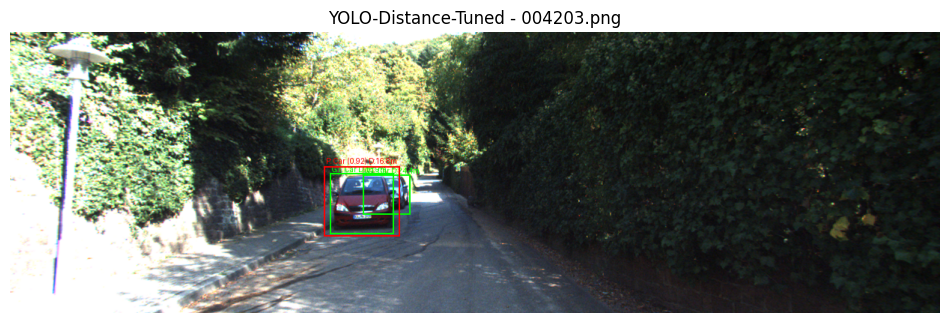

Processing image 2/200: 005034.png for model YOLO-Distance-Tuned
1/1 [==============================] - 0s 47ms/step

DEBUG: Ground Truth objects for 005034.png (first 3):
  GT 0: class=Car, distance=10.64
  GT 1: class=Car, distance=15.98
  GT 2: class=Van, distance=23.03

DEBUG: Raw predictions for 005034.png (first 3):
  Pred 0: class_id=1, score=0.797, distance=11.521065711975098
  Pred 1: class_id=1, score=0.781, distance=16.71111488342285
  Pred 2: class_id=1, score=0.461, distance=10.820940971374512

DEBUG: Creating formatted prediction boxes for drawing:
  Formatted Box 0: [691.294113824242, 173.66976078227162, 839.3198683261871, 283.33216584062103, 'Car', 0.7973774671554565, 11.521065711975098]
  - Distance value: 11.521065711975098, type: <class 'float'>
  Formatted Box 1: [679.7689359748834, 162.74320223888284, 773.871999822557, 256.3320784023718, 'Car', 0.7814452052116394, 16.71111488342285]
  - Distance value: 16.71111488342285, type: <class 'float'>
  Formatted Box 2: [73

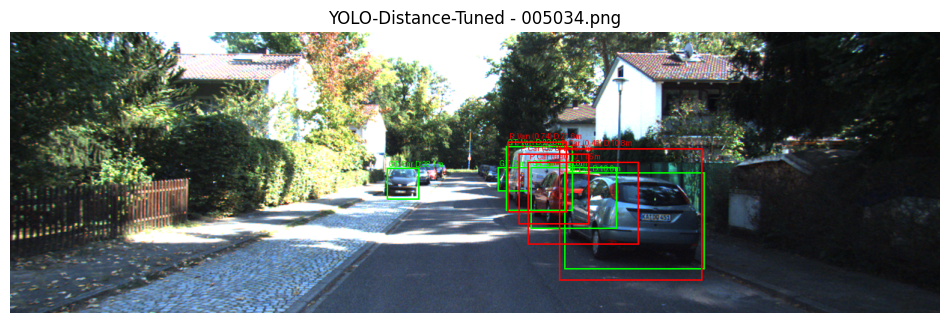

Processing image 3/200: 004024.png for model YOLO-Distance-Tuned
1/1 [==============================] - 0s 33ms/step

DEBUG: Ground Truth objects for 004024.png (first 3):
  GT 0: class=Pedestrian, distance=11.52
  GT 1: class=Pedestrian, distance=13.56

DEBUG: Raw predictions for 004024.png (first 3):
  Pred 0: class_id=5, score=0.326, distance=11.038883209228516
  Pred 1: class_id=5, score=0.256, distance=7.442008972167969
  Pred 2: class_id=6, score=0.207, distance=28.94481086730957

DEBUG: Creating formatted prediction boxes for drawing:
  Formatted Box 0: [745.0355684129815, 156.35337639354952, 801.739732466246, 252.02956520383688, 'Cyclist', 0.32614293694496155, 11.038883209228516]
  - Distance value: 11.038883209228516, type: <class 'float'>
  Formatted Box 1: [810.6742674043696, 154.59636213306925, 857.9012854858056, 263.1200271716439, 'Cyclist', 0.2562004327774048, 7.442008972167969]
  - Distance value: 7.442008972167969, type: <class 'float'>
  Formatted Box 2: [467.592707662

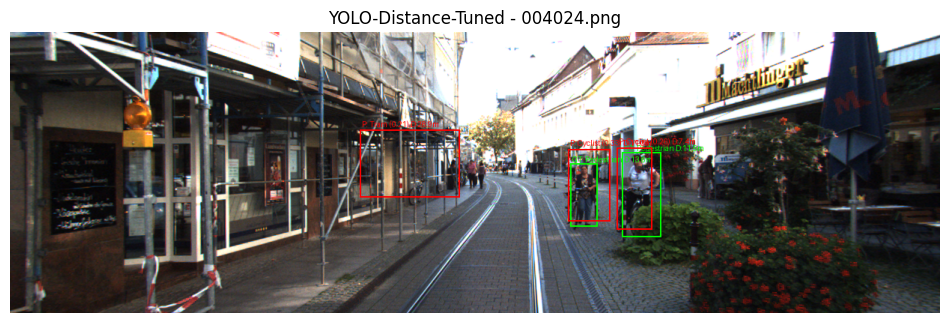

Processing image 4/200: 001498.png for model YOLO-Distance-Tuned
1/1 [==============================] - 0s 33ms/step
Processing image 5/200: 002440.png for model YOLO-Distance-Tuned
1/1 [==============================] - 0s 32ms/step
Processing image 6/200: 004874.png for model YOLO-Distance-Tuned
1/1 [==============================] - 0s 32ms/step
Processing image 7/200: 007177.png for model YOLO-Distance-Tuned
1/1 [==============================] - 0s 33ms/step
Processing image 8/200: 003207.png for model YOLO-Distance-Tuned
1/1 [==============================] - 0s 33ms/step
Processing image 9/200: 002026.png for model YOLO-Distance-Tuned
1/1 [==============================] - 0s 32ms/step
Processing image 10/200: 005915.png for model YOLO-Distance-Tuned
1/1 [==============================] - 0s 32ms/step
Processing image 11/200: 001420.png for model YOLO-Distance-Tuned
1/1 [==============================] - 0s 33ms/step
Processing image 12/200: 001889.png for model YOLO-Distance-Tu

In [9]:
# Cell 9: Run Evaluation for Tuned Model
print("--- Cell 9: Evaluating Tuned Model ---")
results_tuned = None 
if selected_test_filenames and model_body_tuned:
    print("Starting evaluation for YOLO-Distance-Tuned...")
    results_tuned = evaluate_model_on_images(
        model_name_str="YOLO-Distance-Tuned", model_body_instance=model_body_tuned,
        image_filenames_list=selected_test_filenames, images_dir=normal_images_base_path,
        gt_labels_dir=labels_base_path, class_names_list_cfg=class_names,
        eval_conf_threshold=CONF_THRESHOLD_DETECTION, eval_iou_threshold=IOU_THRESHOLD_EVAL,
        eval_nms_iou_threshold=NMS_IOU_THRESHOLD, num_total_classes_cfg=num_classes,
        model_input_size_hw_cfg=config_params['model_image_size'], anchors_cfg_full=anchors,
        display_n_images=3 
    )
else:
    print("Skipping Tuned Model evaluation: Model (model_body_tuned) or test filenames not available.")
print("--- Cell 9: Tuned Model Evaluation Complete ---")

# Parameters for the Blurred Model Evaluation

Below are the specific parameters and configurations used when evaluating the YOLO model trained on blurred images.

> **Note:** The detection threshold (`CONF_THRESHOLD_DETECTION`) was manually adjusted for this model during comparative analysis. The value used for this specific run would be detailed below.

---

*(At this point, you would typically list the specific parameters. If many are inherited from a general configuration, you might only list the overrides or key settings for this particular model's evaluation.)*

For example:

* **Model Weights Path**: `blurred_model_weights_path` (as defined in Cell 1: `/Users/teaguesangster/Code/Python/ComputerVisionFinal/runs/blurred/yolo-distance-blured_best.h5`)
* **Image Source**: `blurred_images_base_path` (as defined in Cell 1)
* **Confidence Threshold for Detection (`CONF_THRESHOLD_DETECTION`)**: *[Manually adjusted value for this run, e.g., 0.15 or as per your specific test]*
* **IOU Threshold for Evaluation (`IOU_THRESHOLD_EVAL`)**: *[Value used, e.g., 0.7 or as per Cell 1]*
* **NMS IOU Threshold (`NMS_IOU_THRESHOLD`)**: *[Value used, e.g., 0.45 or as per Cell 1]*
* **Other relevant evaluation parameters specific to this test...**

---

--- Cell 10: Evaluating Blurred Model ---
Starting evaluation for YOLO-Distance-Blurred...

--- Starting Evaluation for Model: YOLO-Distance-Blurred ---
Processing image 1/200: 004203.png for model YOLO-Distance-Blurred


2025-05-12 16:27:06.110118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 617ms/step
  Raw feature map shapes for 004203.png: [(1, 19, 19, 39), (1, 38, 38, 39), (1, 76, 76, 39)]
  Decoding feature map 0
    Feature Map Slice (raw logits) for xy: min=-0.12, max=0.11, mean=0.00
    Feature Map Slice (raw logits) for wh: min=-0.12, max=0.08, mean=-0.01
    Feature Map Slice (raw logits) for obj: min=-1.30, max=-0.02, mean=-0.72
    Feature Map Slice (raw logits) for classes: min=-0.90, max=0.28, mean=-0.30
    Feature Map Slice (raw logits) for dist: min=0.14, max=1.62, mean=0.76
    Decoded Objectness: min=0.214, max=0.495, mean=0.330
    Decoded Max Class Prob per anchor: min=0.460, max=0.571
    Decoded box_wh (normalized): min_w=0.183, max_w=0.635, min_h=0.145, max_h=0.553
  Decoding feature map 1
    Feature Map Slice (raw logits) for xy: min=-1.11, max=1.01, mean=-0.02
    Feature Map Slice (raw logits) for wh: min=-1.06, max=1.13, mean=0.04
    Feature Map Slice (raw logits) for obj: min=-8.70, max=-0.35, mean=-1

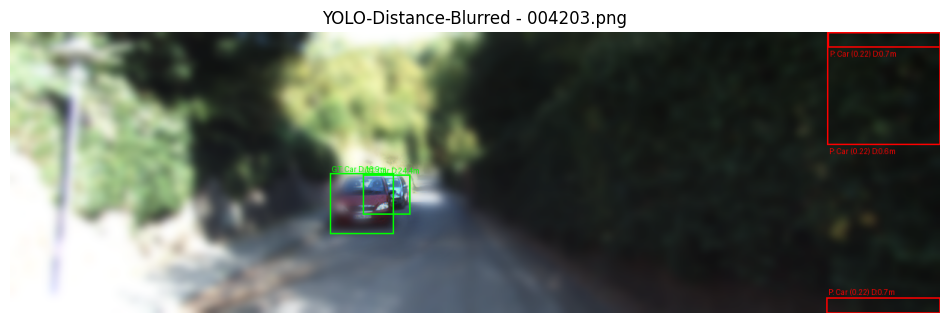

Processing image 2/200: 005034.png for model YOLO-Distance-Blurred
1/1 [==============================] - 0s 43ms/step

DEBUG: Ground Truth objects for 005034.png (first 3):
  GT 0: class=Car, distance=10.64
  GT 1: class=Car, distance=15.98
  GT 2: class=Van, distance=23.03

DEBUG: Raw predictions for 005034.png (first 3):
  Pred 0: class_id=1, score=0.253, distance=0.37165647745132446
  Pred 1: class_id=1, score=0.251, distance=0.3548496961593628
  Pred 2: class_id=1, score=0.251, distance=0.361244261264801

DEBUG: Creating formatted prediction boxes for drawing:
  Formatted Box 0: [-83.86354490800908, 684.8738584808613, 149.13950767485719, 867.9385905226594, 'Car', 0.25307661294937134, 0.37165647745132446]
  - Distance value: 0.37165647745132446, type: <class 'float'>
  Formatted Box 1: [-85.29733286209796, -493.4285708516836, 150.47366042944947, -307.40713153622653, 'Car', 0.2514749765396118, 0.3548496961593628]
  - Distance value: 0.3548496961593628, type: <class 'float'>
  Format

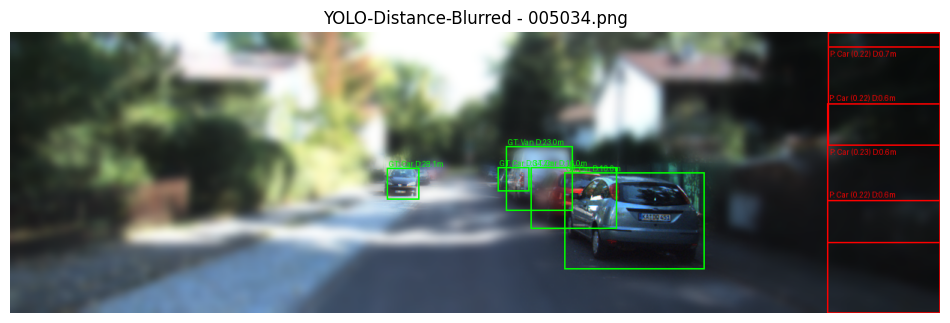

Processing image 3/200: 004024.png for model YOLO-Distance-Blurred
1/1 [==============================] - 0s 39ms/step

DEBUG: Ground Truth objects for 004024.png (first 3):
  GT 0: class=Pedestrian, distance=11.52
  GT 1: class=Pedestrian, distance=13.56

DEBUG: Raw predictions for 004024.png (first 3):
  Pred 0: class_id=1, score=0.253, distance=0.33956408500671387
  Pred 1: class_id=1, score=0.252, distance=0.3891529142856598
  Pred 2: class_id=1, score=0.251, distance=0.37753742933273315

DEBUG: Creating formatted prediction boxes for drawing:
  Formatted Box 0: [-85.19770472457535, -493.41263246340185, 150.37274262936492, -307.41747099670926, 'Car', 0.2527475953102112, 0.33956408500671387]
  - Distance value: 0.33956408500671387, type: <class 'float'>
  Formatted Box 1: [-83.79465632571986, 684.9802088870814, 149.04321668532333, 867.9279946394656, 'Car', 0.2518680989742279, 0.3891529142856598]
  - Distance value: 0.3891529142856598, type: <class 'float'>
  Formatted Box 2: [1090.3

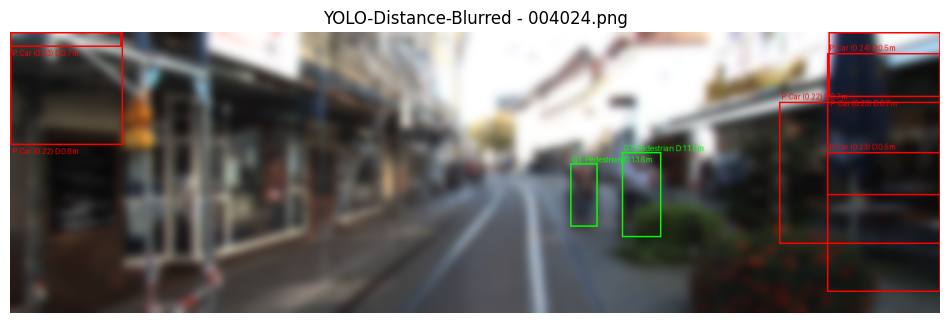

Processing image 4/200: 001498.png for model YOLO-Distance-Blurred
1/1 [==============================] - 0s 37ms/step
Processing image 5/200: 002440.png for model YOLO-Distance-Blurred
1/1 [==============================] - 0s 37ms/step
Processing image 6/200: 004874.png for model YOLO-Distance-Blurred
1/1 [==============================] - 0s 34ms/step
Processing image 7/200: 007177.png for model YOLO-Distance-Blurred
1/1 [==============================] - 0s 32ms/step
Processing image 8/200: 003207.png for model YOLO-Distance-Blurred
1/1 [==============================] - 0s 33ms/step
Processing image 9/200: 002026.png for model YOLO-Distance-Blurred
1/1 [==============================] - 0s 34ms/step
Processing image 10/200: 005915.png for model YOLO-Distance-Blurred
1/1 [==============================] - 0s 35ms/step
Processing image 11/200: 001420.png for model YOLO-Distance-Blurred
1/1 [==============================] - 0s 34ms/step
Processing image 12/200: 001889.png for model 

In [10]:
# Cell 10: Run Evaluation for Blurred Model
print("--- Cell 10: Evaluating Blurred Model ---")

results_blurred = None # Initialize
if selected_test_filenames and model_body_blurred:
    print("Starting evaluation for YOLO-Distance-Blurred...")
    results_blurred = evaluate_model_on_images(
        model_name_str="YOLO-Distance-Blurred",
        model_body_instance=model_body_blurred,
        image_filenames_list=selected_test_filenames,
        images_dir=blurred_images_base_path, # Use blurred images
        gt_labels_dir=labels_base_path,
        class_names_list_cfg=class_names,
        eval_conf_threshold=.22,
        eval_iou_threshold=IOU_THRESHOLD_EVAL,
        eval_nms_iou_threshold=NMS_IOU_THRESHOLD,
        num_total_classes_cfg=num_classes,
        model_input_size_hw_cfg=config_params['model_image_size'],
        anchors_cfg_full=anchors,
        display_n_images=3
    )
else:
    print("Skipping Blurred Model evaluation: Model or test filenames not available, or model failed to load.")
    
print("--- Cell 10: Blurred Model Evaluation Complete ---")

# Cell 12: Evaluation of Tuned Model on Blurred Dataset

This cell evaluates the **YOLO-Distance-Tuned** model (the one trained on standard, clear images). The key purpose here is to test its performance specifically on the **blurred image dataset**. This helps understand how the standard model's performance degrades under simulated adverse visibility conditions.

---

### Process Overview:

* **Conditional Execution**:
    * The evaluation runs only if the tuned model (`model_body_tuned`) has been loaded and the list of test image filenames (`selected_test_filenames`) is available.
    * If either is missing, a message is printed, and this evaluation step is skipped.

* **Evaluation Function Call**:
    * If the prerequisites are met, the `evaluate_model_on_images` function is called.
    * It assesses the "YOLO-Distance-Tuned-On-Blurred" model configuration using:
        * **Test Images**: Selected from the **`blurred_images_base_path`** (the dataset containing artificially blurred images).
        * **Ground Truth Labels**: Sourced from `labels_base_path`.
        * **Model Instance**: The `model_body_tuned` instance.
        * **Configuration**: Employs the global settings from Cell 1 (like `class_names`, various thresholds, `num_classes`, `model_image_size`, `anchors`).
        * **Visualization**: Set to display `3` example images showing the tuned model's detections on the blurred images compared to the ground truth.

* **Results Storage**:
    * Performance metrics and other outputs for this specific test case (tuned model on blurred data) are stored in the `results_tuned_on_blurred` variable.

---

A status message confirms the completion (or skipping) of the evaluation process for the tuned model when applied to the blurred dataset.

--- Cell 12: Evaluating Tuned Model on Blurred Dataset ---
Starting evaluation for YOLO-Distance-Tuned on blurred images...

--- Starting Evaluation for Model: YOLO-Distance-Tuned-On-Blurred ---
Processing image 1/200: 004203.png for model YOLO-Distance-Tuned-On-Blurred
1/1 [==============================] - 0s 32ms/step
  Raw feature map shapes for 004203.png: [(1, 19, 19, 39), (1, 38, 38, 39), (1, 76, 76, 39)]
  Decoding feature map 0
    Feature Map Slice (raw logits) for xy: min=-4.20, max=3.31, mean=-0.06
    Feature Map Slice (raw logits) for wh: min=-1.75, max=1.81, mean=-0.01
    Feature Map Slice (raw logits) for obj: min=-33.38, max=-8.60, mean=-19.80
    Feature Map Slice (raw logits) for classes: min=-18.29, max=13.09, mean=-6.13
    Feature Map Slice (raw logits) for dist: min=0.12, max=34.10, mean=9.64
    Decoded Objectness: min=0.000, max=0.000, mean=0.000
    Decoded Max Class Prob per anchor: min=0.025, max=1.000
    Decoded box_wh (normalized): min_w=0.051, max_w=1.1

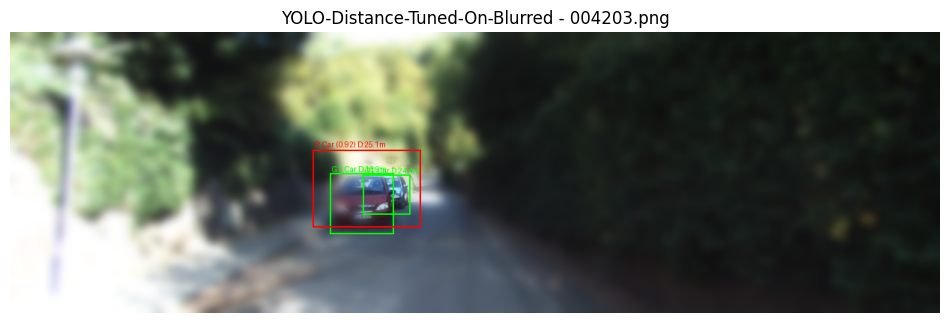

Processing image 2/200: 005034.png for model YOLO-Distance-Tuned-On-Blurred
1/1 [==============================] - 0s 43ms/step

DEBUG: Ground Truth objects for 005034.png (first 3):
  GT 0: class=Car, distance=10.64
  GT 1: class=Car, distance=15.98
  GT 2: class=Van, distance=23.03

DEBUG: Raw predictions for 005034.png (first 3):
  Pred 0: class_id=1, score=0.725, distance=21.002792358398438
  Pred 1: class_id=1, score=0.595, distance=27.959129333496094
  Pred 2: class_id=1, score=0.503, distance=14.194068908691406

DEBUG: Creating formatted prediction boxes for drawing:
  Formatted Box 0: [725.4148265378255, 156.91049740953665, 941.4751724502757, 311.8096383294385, 'Car', 0.7249767780303955, 21.002792358398438]
  - Distance value: 21.002792358398438, type: <class 'float'>
  Formatted Box 1: [681.5171955792528, 156.9801443017235, 787.5150329909826, 251.6484176216549, 'Car', 0.5949467420578003, 27.959129333496094]
  - Distance value: 27.959129333496094, type: <class 'float'>
  Format

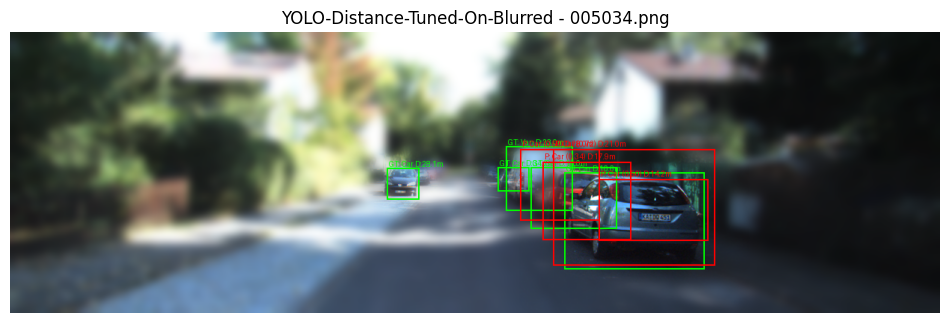

Processing image 3/200: 004024.png for model YOLO-Distance-Tuned-On-Blurred
1/1 [==============================] - 0s 45ms/step

DEBUG: Ground Truth objects for 004024.png (first 3):
  GT 0: class=Pedestrian, distance=11.52
  GT 1: class=Pedestrian, distance=13.56

DEBUG: Raw predictions for 004024.png (first 3):

DEBUG: Creating formatted prediction boxes for drawing:

DEBUG: Drawing GT boxes...
DEBUG: Processing 2 GT boxes
DEBUG: GT Box 0: Distance value: 11.52, type: <class 'float'>
DEBUG: Final GT dist_val to display: 11.52
DEBUG: GT Label text: GT: Pedestrian D:11.5m
DEBUG: GT Box 1: Distance value: 13.56, type: <class 'float'>
DEBUG: Final GT dist_val to display: 13.56
DEBUG: GT Label text: GT: Pedestrian D:13.6m

DEBUG: Drawing prediction boxes...
DEBUG: Processing 0 prediction boxes


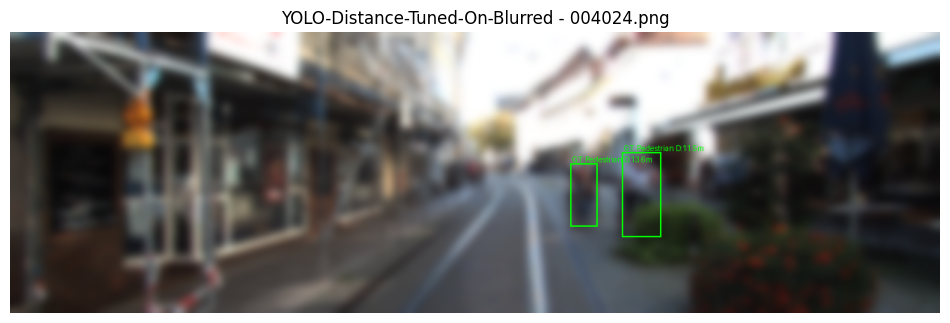

Processing image 4/200: 001498.png for model YOLO-Distance-Tuned-On-Blurred
1/1 [==============================] - 0s 40ms/step
Processing image 5/200: 002440.png for model YOLO-Distance-Tuned-On-Blurred
1/1 [==============================] - 0s 32ms/step
Processing image 6/200: 004874.png for model YOLO-Distance-Tuned-On-Blurred
1/1 [==============================] - 0s 32ms/step
Processing image 7/200: 007177.png for model YOLO-Distance-Tuned-On-Blurred
1/1 [==============================] - 0s 32ms/step
Processing image 8/200: 003207.png for model YOLO-Distance-Tuned-On-Blurred
1/1 [==============================] - 0s 32ms/step
Processing image 9/200: 002026.png for model YOLO-Distance-Tuned-On-Blurred
1/1 [==============================] - 0s 31ms/step
Processing image 10/200: 005915.png for model YOLO-Distance-Tuned-On-Blurred
1/1 [==============================] - 0s 32ms/step
Processing image 11/200: 001420.png for model YOLO-Distance-Tuned-On-Blurred
1/1 [=====================

In [11]:
# Cell 11: Run Evaluation for Tuned Model on Blurred Dataset
print("--- Cell 12: Evaluating Tuned Model on Blurred Dataset ---")
results_tuned_on_blurred = None 
if selected_test_filenames and model_body_tuned:
    print("Starting evaluation for YOLO-Distance-Tuned on blurred images...")
    results_tuned_on_blurred = evaluate_model_on_images(
        model_name_str="YOLO-Distance-Tuned-On-Blurred", 
        model_body_instance=model_body_tuned,
        image_filenames_list=selected_test_filenames, 
        images_dir=blurred_images_base_path,  # Use blurred images
        gt_labels_dir=labels_base_path, 
        class_names_list_cfg=class_names,
        eval_conf_threshold=CONF_THRESHOLD_DETECTION, 
        eval_iou_threshold=IOU_THRESHOLD_EVAL,
        eval_nms_iou_threshold=NMS_IOU_THRESHOLD, 
        num_total_classes_cfg=num_classes,
        model_input_size_hw_cfg=config_params['model_image_size'], 
        anchors_cfg_full=anchors,
        display_n_images=3 
    )
else:
    print("Skipping Tuned Model evaluation on blurred dataset: Model or test filenames not available.")
print("--- Cell 12: Tuned Model Evaluation on Blurred Dataset Complete ---")

# Cell 13: Evaluation of Blurred Model on Normal Dataset

This cell conducts an evaluation of the **YOLO-Distance-Blurred** model (the model trained on artificially blurred images). Critically, this evaluation is performed using the **normal (clear) image dataset**. This helps assess how the model trained for adverse conditions performs on standard input.

---

### Process Overview:

* **Conditional Execution**:
    * The evaluation proceeds only if both the blurred model (`model_body_blurred`) has been loaded and a list of test image filenames (`selected_test_filenames`) is available.
    * If these conditions are not met, a message indicates that this evaluation step is skipped.

* **Evaluation Function Call**:
    * When the prerequisites are satisfied, the `evaluate_model_on_images` function is called.
    * This function assesses the "YOLO-Distance-Blurred-On-Normal" model variant:
        * **Test Images**: Crucially, it uses the `selected_test_filenames` from the **`normal_images_base_path`** (the dataset of clear images).
        * **Ground Truth Labels**: Sourced from `labels_base_path`.
        * **Model Instance**: The `model_body_blurred` instance.
        * **Configuration**: It employs the global settings defined in Cell 1 (e.g., `class_names`, `CONF_THRESHOLD_DETECTION`, `IOU_THRESHOLD_EVAL`, `NMS_IOU_THRESHOLD`, `num_classes`, `model_image_size`, `anchors`).
        * **Visualization**: Configured to display `3` example images, showing detections from the blurred model on the clear images alongside their ground truth.

* **Results Storage**:
    * The outcomes and performance metrics from this specific evaluation (blurred model on normal images) are stored in the `results_blurred_on_normal` variable.

---

A status message confirms the completion (or skipping) of the evaluation process for the blurred model on the normal dataset.

--- Cell 13: Evaluating Blurred Model on Normal Dataset ---
Starting evaluation for YOLO-Distance-Blurred on normal images...

--- Starting Evaluation for Model: YOLO-Distance-Blurred-On-Normal ---
Processing image 1/200: 004203.png for model YOLO-Distance-Blurred-On-Normal
1/1 [==============================] - 0s 89ms/step
  Raw feature map shapes for 004203.png: [(1, 19, 19, 39), (1, 38, 38, 39), (1, 76, 76, 39)]
  Decoding feature map 0
    Feature Map Slice (raw logits) for xy: min=-0.11, max=0.18, mean=0.01
    Feature Map Slice (raw logits) for wh: min=-0.11, max=0.09, mean=-0.01
    Feature Map Slice (raw logits) for obj: min=-1.74, max=-0.02, mean=-0.67
    Feature Map Slice (raw logits) for classes: min=-1.01, max=0.36, mean=-0.28
    Feature Map Slice (raw logits) for dist: min=0.14, max=1.96, mean=0.71
    Decoded Objectness: min=0.149, max=0.496, mean=0.342
    Decoded Max Class Prob per anchor: min=0.447, max=0.588
    Decoded box_wh (normalized): min_w=0.174, max_w=0.635

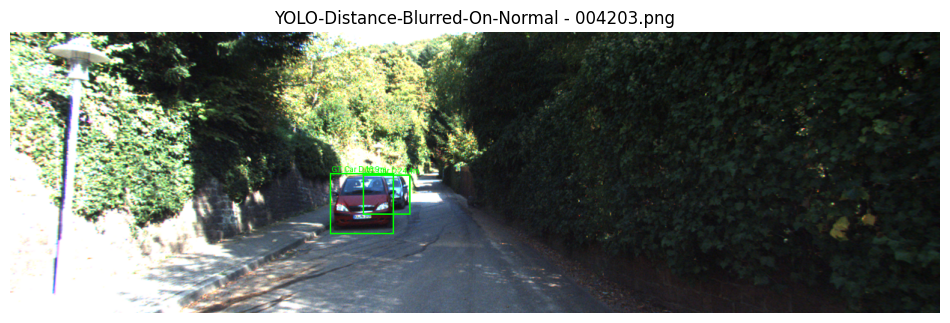

Processing image 2/200: 005034.png for model YOLO-Distance-Blurred-On-Normal
1/1 [==============================] - 0s 93ms/step

DEBUG: Ground Truth objects for 005034.png (first 3):
  GT 0: class=Car, distance=10.64
  GT 1: class=Car, distance=15.98
  GT 2: class=Van, distance=23.03

DEBUG: Raw predictions for 005034.png (first 3):
  Pred 0: class_id=1, score=0.254, distance=0.35328397154808044
  Pred 1: class_id=1, score=0.253, distance=0.33379054069519043
  Pred 2: class_id=1, score=0.252, distance=0.3672824800014496

DEBUG: Creating formatted prediction boxes for drawing:
  Formatted Box 0: [-84.10094558329959, 684.8422169410868, 149.35833876776067, 867.9620031581113, 'Car', 0.2544081509113312, 0.35328397154808044]
  - Distance value: 0.35328397154808044, type: <class 'float'>
  Formatted Box 1: [-85.27181283619844, -493.3837959884029, 150.38926789203757, -307.48184527299907, 'Car', 0.2527957558631897, 0.33379054069519043]
  - Distance value: 0.33379054069519043, type: <class 'flo

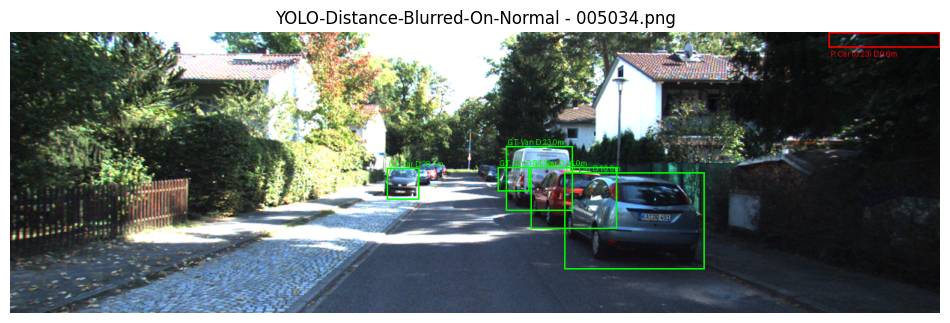

Processing image 3/200: 004024.png for model YOLO-Distance-Blurred-On-Normal
1/1 [==============================] - 0s 87ms/step

DEBUG: Ground Truth objects for 004024.png (first 3):
  GT 0: class=Pedestrian, distance=11.52
  GT 1: class=Pedestrian, distance=13.56

DEBUG: Raw predictions for 004024.png (first 3):
  Pred 0: class_id=1, score=0.253, distance=0.3760509490966797
  Pred 1: class_id=1, score=0.253, distance=0.33046674728393555
  Pred 2: class_id=1, score=0.252, distance=0.3652488589286804

DEBUG: Creating formatted prediction boxes for drawing:
  Formatted Box 0: [-84.14498770589891, 684.8192072034274, 149.39111679831618, 867.949853031847, 'Car', 0.2531869113445282, 0.3760509490966797]
  - Distance value: 0.3760509490966797, type: <class 'float'>
  Formatted Box 1: [-85.31293933760179, -493.2721247500495, 150.45443822325845, -307.5837719613, 'Car', 0.25306472182273865, 0.33046674728393555]
  - Distance value: 0.33046674728393555, type: <class 'float'>
  Formatted Box 2: [50

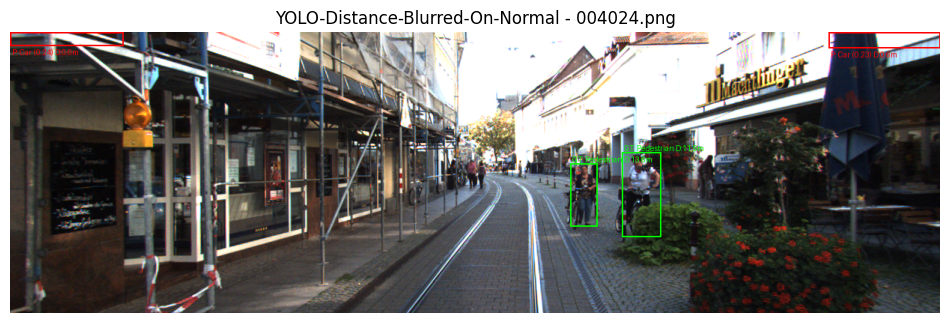

Processing image 4/200: 001498.png for model YOLO-Distance-Blurred-On-Normal
1/1 [==============================] - 0s 87ms/step
Processing image 5/200: 002440.png for model YOLO-Distance-Blurred-On-Normal
1/1 [==============================] - 0s 90ms/step
Processing image 6/200: 004874.png for model YOLO-Distance-Blurred-On-Normal
1/1 [==============================] - 0s 90ms/step
Processing image 7/200: 007177.png for model YOLO-Distance-Blurred-On-Normal
1/1 [==============================] - 0s 90ms/step
Processing image 8/200: 003207.png for model YOLO-Distance-Blurred-On-Normal
1/1 [==============================] - 0s 86ms/step
Processing image 9/200: 002026.png for model YOLO-Distance-Blurred-On-Normal
1/1 [==============================] - 0s 88ms/step
Processing image 10/200: 005915.png for model YOLO-Distance-Blurred-On-Normal
1/1 [==============================] - 0s 89ms/step
Processing image 11/200: 001420.png for model YOLO-Distance-Blurred-On-Normal
1/1 [=============

In [12]:
# Cell 12: Run Evaluation for Blurred Model on Normal Dataset
print("--- Cell 13: Evaluating Blurred Model on Normal Dataset ---")
results_blurred_on_normal = None 
if selected_test_filenames and model_body_blurred:
    print("Starting evaluation for YOLO-Distance-Blurred on normal images...")
    results_blurred_on_normal = evaluate_model_on_images(
        model_name_str="YOLO-Distance-Blurred-On-Normal", 
        model_body_instance=model_body_blurred,
        image_filenames_list=selected_test_filenames, 
        images_dir=normal_images_base_path,  # Use normal images
        gt_labels_dir=labels_base_path, 
        class_names_list_cfg=class_names,
        eval_conf_threshold=CONF_THRESHOLD_DETECTION, 
        eval_iou_threshold=IOU_THRESHOLD_EVAL,
        eval_nms_iou_threshold=NMS_IOU_THRESHOLD, 
        num_total_classes_cfg=num_classes,
        model_input_size_hw_cfg=config_params['model_image_size'], 
        anchors_cfg_full=anchors,
        display_n_images=3 
    )
else:
    print("Skipping Blurred Model evaluation on normal dataset: Model or test filenames not available.")
print("--- Cell 13: Blurred Model Evaluation on Normal Dataset Complete ---")

# Cell 13: Results Comparison, Plotting, and Summary

This cell consolidates and visually compares the performance results from up to four different model-dataset evaluation combinations:
1.  Tuned Model on Normal Dataset
2.  Blurred Model on Blurred Dataset
3.  Tuned Model on Blurred Dataset
4.  Blurred Model on Normal Dataset

The primary goal is to generate comparative tables and plots to analyze model performance across these scenarios.

---

### Process Overview:

1.  **Availability Check**:
    * The cell first verifies which of the four potential evaluation results (`results_tuned`, `results_blurred`, `results_tuned_on_blurred`, `results_blurred_on_normal`) are actually available.
    * A minimum of two distinct evaluation results are required to proceed with a meaningful comparison. If this condition isn't met, a message is displayed, and further processing is limited.

2.  **Per-Class Comparative Metrics Table**:
    * If sufficient data is available, this section compiles detailed performance metrics for each object class.
    * **Metrics Displayed**: `Precision`, `Recall`, `F1-score`, along with raw counts of True Positives (`TP`), False Positives (`FP`), False Negatives (`FN`), and total Ground Truth (`GT`) objects per class.
    * **Data Compilation**: For each class, results are gathered from all available model-dataset combinations, creating a comprehensive row for each.
    * **Output**: A Pandas DataFrame is created and printed, offering a clear tabular comparison of how each model configuration performed on each class.

3.  **Overall Summary Metrics Table**:
    * A high-level summary table is constructed to provide a bird's-eye view of performance.
    * **Metrics Included**:
        * Simplified mAP (Recall-based)
        * Distance MAE (meters)
        * Distance Median AE (meters)
        * Total Ground Truth Objects
        * Total Predictions (Post-NMS)
        * Total True Positives
    * **Data Compilation**: Values for these metrics are populated for each available model-dataset combination. The comments note that `0` or `NaN` values in this table can indicate errors or sections that failed to run.
    * **Output**: A Pandas DataFrame is created (with 'Metric' as the index) and printed.

4.  **Visualizations (if sufficient data exists)**:

    * **Bar Charts for Per-Class Metrics**:
        * **Purpose**: To visually compare `Precision`, `Recall`, and `F1-Score` across all available model-dataset combinations for each class.
        * **Process**: A dedicated function `plot_comparison_bars` is used to generate these charts. It prepares the data from the results and uses `matplotlib` to create and display the bar charts.
        * Separate plots are generated for Precision, Recall, and F1-score.

    * **Distance MAE Comparison Bar Chart**:
        * **Purpose**: Specifically visualizes the Mean Absolute Error (MAE) in distance estimation for each model-dataset combination. Lower MAE values indicate better performance.
        * **Process**: Data (model names, MAE values, bar colors) is gathered for available results, and a bar chart is plotted with MAE values labeled on each bar for clarity.

    * **Distribution of Absolute Distance Errors (Box Plot)**:
        * **Purpose**: To provide a statistical overview of the distribution of absolute distance errors for true positive detections. This offers more insight than a simple average, showing spread, central tendency (median), and outliers.
        * **Process**: If distance error lists are available from the evaluation results, a box plot is generated. Labels for each box include the median absolute error for that model-dataset combination.

---

If fewer than two evaluation results are available, a message is printed indicating that a comparison cannot be adequately performed. The cell concludes by printing a message confirming the completion of the comparison and plotting process.

--- Cell 13: Comparing Results and Plotting ---

DEBUG - Available model results:
Tuned (Normal) available: True
Blurred (Blurred) available: True
Tuned (Blurred) available: True
Blurred (Normal) available: True

DEBUG - 4 model results available, proceeding with comparison


--- Per-Class Comparative Metrics ---
                Model           Class   GT   TP     FP   FN  Precision    Recall        F1
0      Tuned (Normal)      Pedestrian  113   38     34   75   0.527778  0.336283  0.410811
1   Blurred (Blurred)      Pedestrian  113    0      0  113   0.000000  0.000000  0.000000
2     Tuned (Blurred)      Pedestrian  113    4      4  109   0.500000  0.035398  0.066116
3    Blurred (Normal)      Pedestrian  113    0      2  113   0.000000  0.000000  0.000000
4      Tuned (Normal)             Car  730  228    142  502   0.616216  0.312329  0.414545
5   Blurred (Blurred)             Car  730    0   8908  730   0.000000  0.000000  0.000000
6     Tuned (Blurred)             Car  730   92 

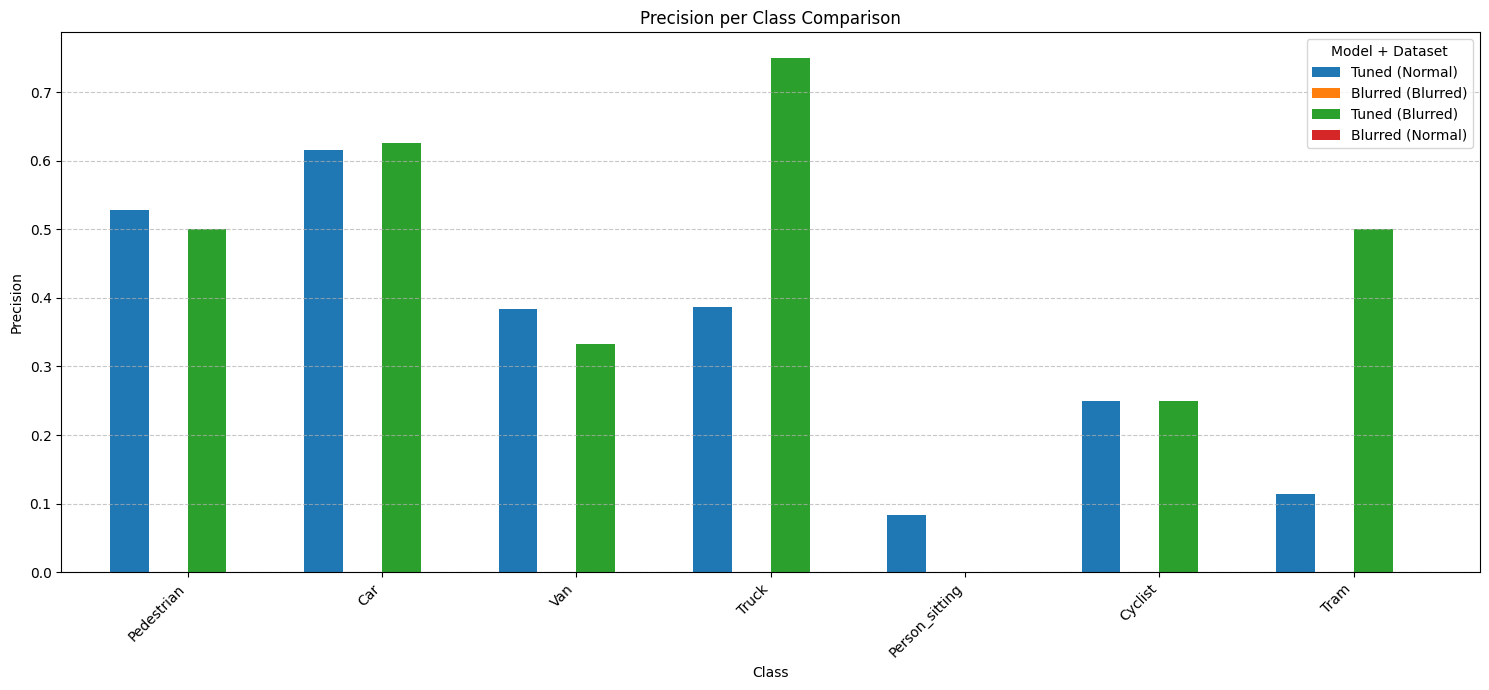

DEBUG - After plt.show() for precision

DEBUG - Attempting to create recall plot

DEBUG - Plot data for recall:
DEBUG - Attempting to display recall plot...


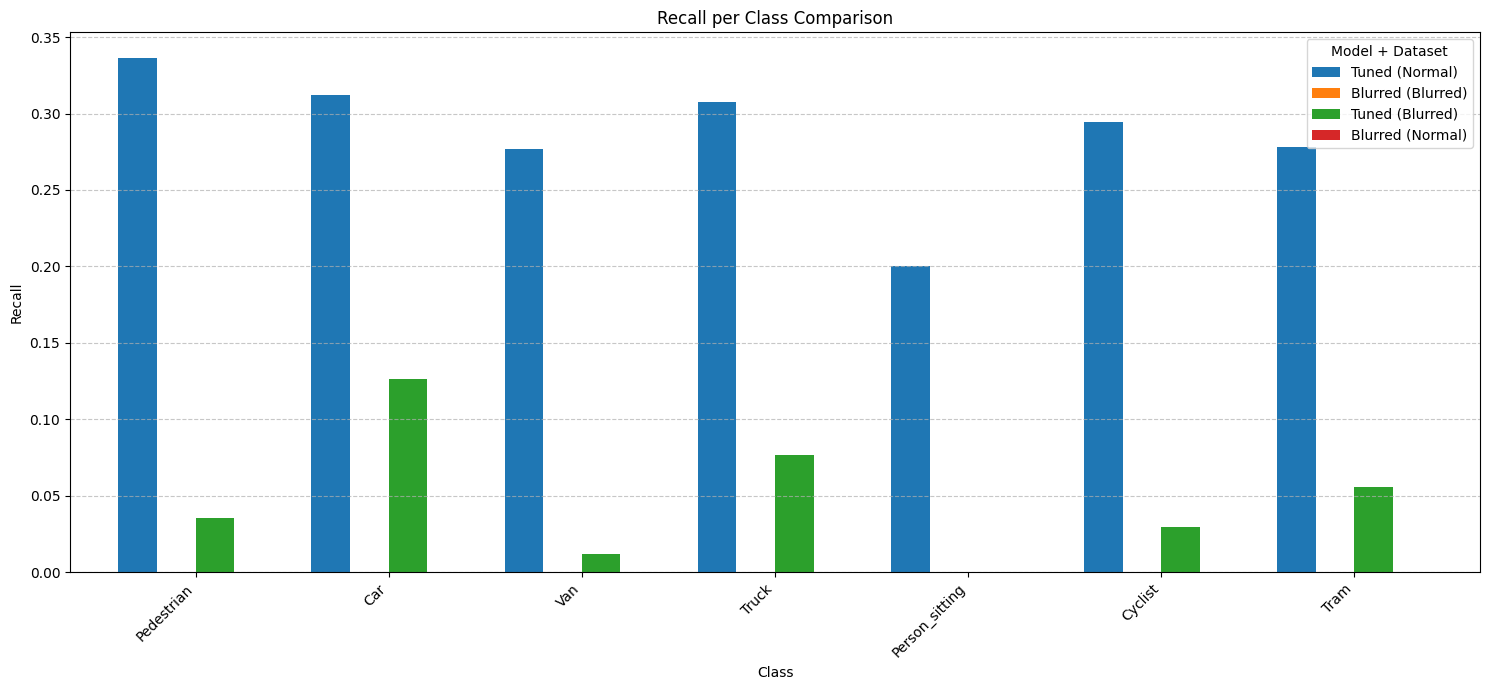

DEBUG - After plt.show() for recall

DEBUG - Attempting to create F1 plot

DEBUG - Plot data for f1:
DEBUG - Attempting to display f1 plot...


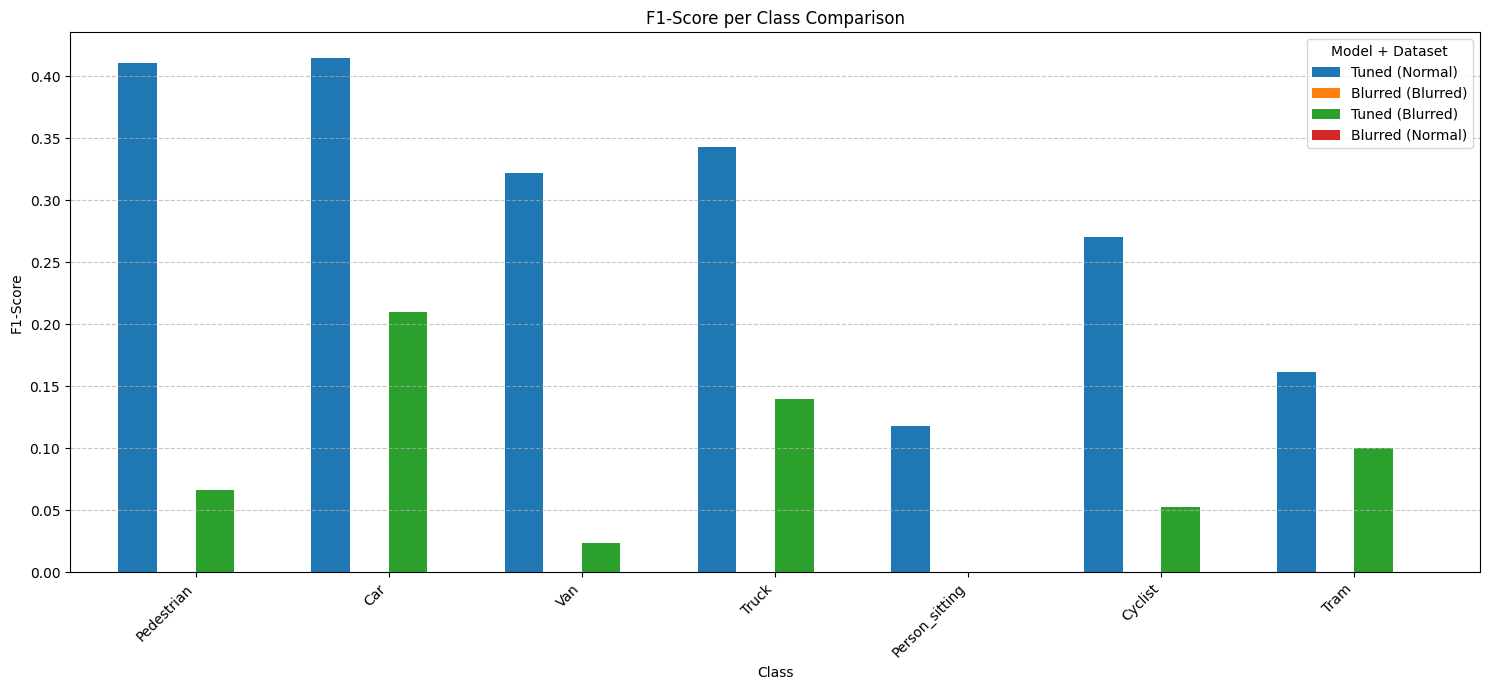

DEBUG - After plt.show() for f1

DEBUG - Setting up Distance MAE plot

DEBUG - Distance MAE data:
Models: ['Tuned (Normal)', 'Blurred (Blurred)', 'Tuned (Blurred)', 'Blurred (Normal)']
MAE values: [2.7593694256161743, nan, 11.324861539269195, nan]
DEBUG - Attempting to display Distance MAE plot...


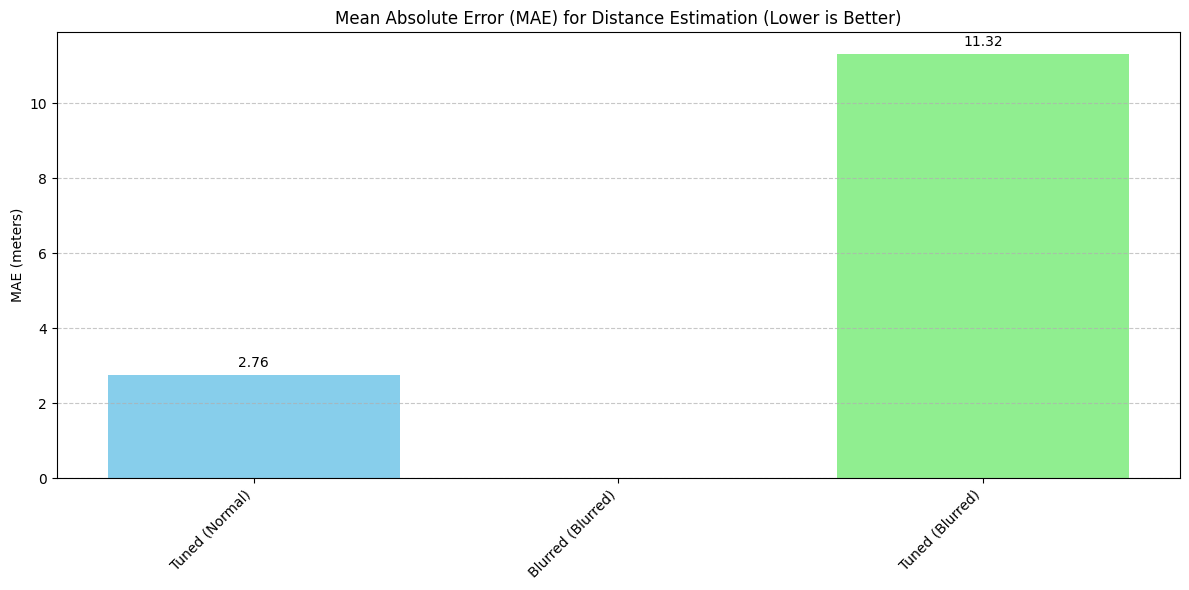

DEBUG - After plt.show() for Distance MAE

DEBUG - Inspecting results dictionaries for distance errors:

--- Tuned (Normal) ---
  Keys available: ['model_name', 'tp_per_class', 'fp_per_class', 'fn_per_class', 'total_gt_per_class', 'precision_per_class', 'recall_per_class', 'f1_per_class', 'simplified_mAP', 'distance_mae', 'distance_median_ae', 'distance_std_ae', 'distance_abs_errors_list', 'total_gt_objects', 'total_predictions_considered', 'total_tp', 'class_names']
  'distance_abs_errors_list' exists.
  'distance_abs_errors_list' type: <class 'list'>
  'distance_abs_errors_list' length: 318
  First 5 errors: [0.0907081604003892, 4.458934288024903, 1.448935775756837, 0.18094097137451115, 1.834916114807129]

--- Blurred (Blurred) ---
  Keys available: ['model_name', 'tp_per_class', 'fp_per_class', 'fn_per_class', 'total_gt_per_class', 'precision_per_class', 'recall_per_class', 'f1_per_class', 'simplified_mAP', 'distance_mae', 'distance_median_ae', 'distance_std_ae', 'distance_abs_error

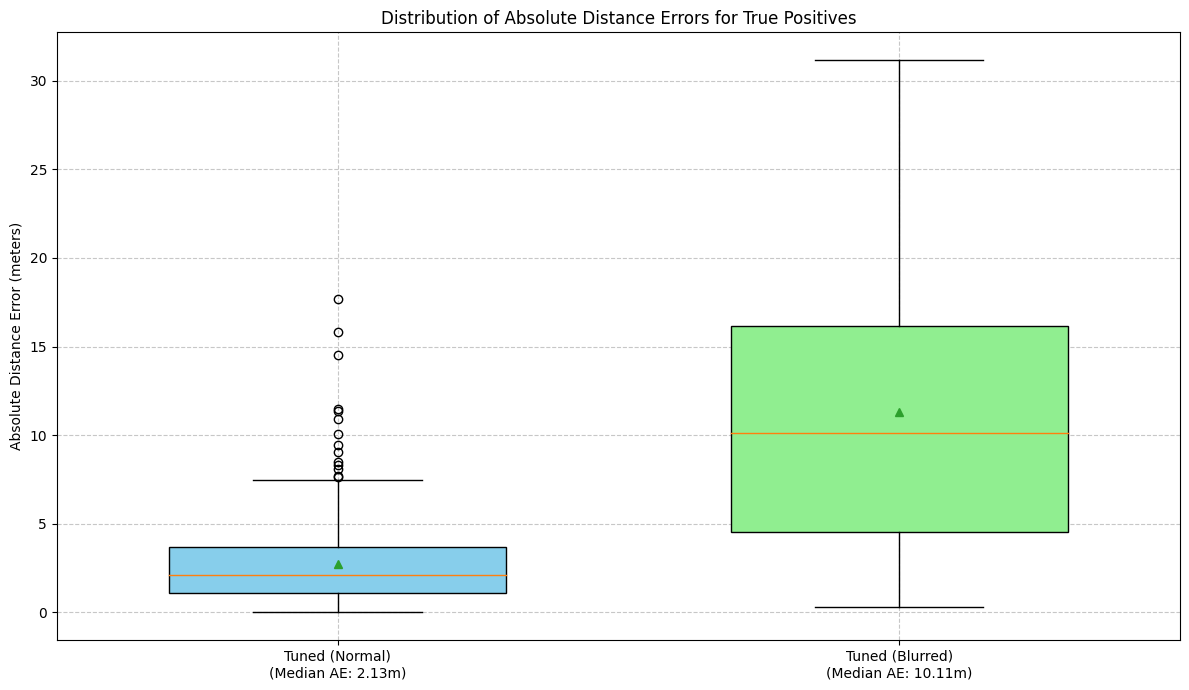

DEBUG - After plt.show() for box plot
--- Cell 13: Comparison and Plotting Complete ---


In [13]:
# Cell 13: Results Comparison, Plotting, and Summary (Updated with all four model-dataset combinations)
print("--- Cell 13: Comparing Results and Plotting ---") # Corrected cell number to match comment

# First, we check whether results are available for each model-dataset combination
# basically making sure we actually have the data required to make a comparison
have_tuned_normal = 'results_tuned' in globals() and results_tuned is not None
have_blurred_blurred = 'results_blurred' in globals() and results_blurred is not None
have_tuned_blurred = 'results_tuned_on_blurred' in globals() and results_tuned_on_blurred is not None
have_blurred_normal = 'results_blurred_on_normal' in globals() and results_blurred_on_normal is not None

# DEBUGGING: Print which model results are available
print("\nDEBUG - Available model results:")
print(f"Tuned (Normal) available: {have_tuned_normal}")
print(f"Blurred (Blurred) available: {have_blurred_blurred}")
print(f"Tuned (Blurred) available: {have_tuned_blurred}")
print(f"Blurred (Normal) available: {have_blurred_normal}")

# We require at least two results to enable meaningful comparison,
# we hopefully have 4 but because the blurred models have been so bad we can't assume
# Count how many results are available
available_results_count = sum([have_tuned_normal, have_blurred_blurred, have_tuned_blurred, have_blurred_normal])

if available_results_count >= 2: # Check if at least two results are available
    print(f"\nDEBUG - {available_results_count} model results available, proceeding with comparison")

    # --- 1. Metrics Table ---
    # These are the same metrics we determined above ->
    metrics_to_display_per_class = ['precision', 'recall', 'f1']
    data_for_df_rows = []

    # Here we combine all of our data for all of our models
    # For each classification category, we compile results across all model-dataset combinations.
    for c_id, class_name_str in enumerate(class_names):
        # Initialize data containers for each model-dataset combination.
        # Each row represents a specific model evaluated on a specific dataset.
        # we have to check for each one bc sometimes we don't have all of them ->
        if have_tuned_normal:
            row_tuned_normal = {'Model': 'Tuned (Normal)', 'Class': class_name_str}

        if have_blurred_blurred:
            row_blurred_blurred = {'Model': 'Blurred (Blurred)', 'Class': class_name_str}

        if have_tuned_blurred:
            row_tuned_blurred = {'Model': 'Tuned (Blurred)', 'Class': class_name_str}

        if have_blurred_normal:
            row_blurred_normal = {'Model': 'Blurred (Normal)', 'Class': class_name_str}

        # Populate each container with the relevant performance metrics.
        # These metrics quantify the model's effectiveness at different aspects of classification.
        for metric_suffix in metrics_to_display_per_class:
            metric_key = f"{metric_suffix}_per_class"

            if have_tuned_normal:
                row_tuned_normal[metric_suffix.capitalize()] = results_tuned[metric_key][c_id]

            if have_blurred_blurred:
                row_blurred_blurred[metric_suffix.capitalize()] = results_blurred[metric_key][c_id]

            if have_tuned_blurred:
                row_tuned_blurred[metric_suffix.capitalize()] = results_tuned_on_blurred[metric_key][c_id]

            if have_blurred_normal:
                row_blurred_normal[metric_suffix.capitalize()] = results_blurred_on_normal[metric_key][c_id]

        # Add classification statistics for further analysis
        if have_tuned_normal:
            row_tuned_normal['TP'] = results_tuned['tp_per_class'][c_id]
            row_tuned_normal['FP'] = results_tuned['fp_per_class'][c_id]
            row_tuned_normal['FN'] = results_tuned['fn_per_class'][c_id]
            row_tuned_normal['GT'] = results_tuned['total_gt_per_class'][c_id]
            data_for_df_rows.append(row_tuned_normal)

        # Repeat for all of our data sets ->
        if have_blurred_blurred:
            row_blurred_blurred['TP'] = results_blurred['tp_per_class'][c_id]
            row_blurred_blurred['FP'] = results_blurred['fp_per_class'][c_id]
            row_blurred_blurred['FN'] = results_blurred['fn_per_class'][c_id]
            row_blurred_blurred['GT'] = results_blurred['total_gt_per_class'][c_id]
            data_for_df_rows.append(row_blurred_blurred)

        if have_tuned_blurred:
            row_tuned_blurred['TP'] = results_tuned_on_blurred['tp_per_class'][c_id]
            row_tuned_blurred['FP'] = results_tuned_on_blurred['fp_per_class'][c_id]
            row_tuned_blurred['FN'] = results_tuned_on_blurred['fn_per_class'][c_id]
            row_tuned_blurred['GT'] = results_tuned_on_blurred['total_gt_per_class'][c_id]
            data_for_df_rows.append(row_tuned_blurred)

        if have_blurred_normal:
            row_blurred_normal['TP'] = results_blurred_on_normal['tp_per_class'][c_id]
            row_blurred_normal['FP'] = results_blurred_on_normal['fp_per_class'][c_id]
            row_blurred_normal['FN'] = results_blurred_on_normal['fn_per_class'][c_id]
            row_blurred_normal['GT'] = results_blurred_on_normal['total_gt_per_class'][c_id]
            data_for_df_rows.append(row_blurred_normal)

    # Create and display the per-class comparison dataframe.
    # This tabular format enables clear visualization of performance differences.
    per_class_comparison_df = pd.DataFrame(data_for_df_rows)
    print("\n\n--- Per-Class Comparative Metrics ---")
    # Ensure correct columns are selected if not all models ran
    cols_to_display_per_class = ['Model', 'Class', 'GT', 'TP', 'FP', 'FN'] + [m.capitalize() for m in metrics_to_display_per_class]
    # Filter out columns that might be all NaN if a metric wasn't calculated (though less likely here)
    # More importantly, just make sure the base columns are there.
    # If per_class_comparison_df is empty, this will error. Check if it has data.
    if not per_class_comparison_df.empty:
        print(per_class_comparison_df[cols_to_display_per_class].to_string())
    else:
        print("Per-class comparison DataFrame is empty. No metrics to display.")


    # --- Overall Summary Metrics Table ---
    # Putting everything in one summary table
    # These numbers don't mean much without a chart but the 0's or NAN's tell us where we have
    # Errors or sections failed to run
    summary_metrics_data = [
        {'Metric': 'Simplified mAP (Recall-based)'},
        {'Metric': 'Distance MAE (m)'},
        {'Metric': 'Distance Median AE (m)'},
        {'Metric': 'Total GT Objects'},
        {'Metric': 'Total Predictions (Post-NMS)'},
        {'Metric': 'Total True Positives'},
    ]

    # Getting our summary tables.
    if have_tuned_normal:
        summary_metrics_data[0]['Tuned (Normal)'] = f"{results_tuned.get('simplified_mAP', 0):.4f}"
        summary_metrics_data[1]['Tuned (Normal)'] = f"{results_tuned.get('distance_mae', float('nan')):.2f}"
        summary_metrics_data[2]['Tuned (Normal)'] = f"{results_tuned.get('distance_median_ae', float('nan')):.2f}"
        summary_metrics_data[3]['Tuned (Normal)'] = results_tuned.get('total_gt_objects', 0)
        summary_metrics_data[4]['Tuned (Normal)'] = results_tuned.get('total_predictions_considered', 0)
        summary_metrics_data[5]['Tuned (Normal)'] = results_tuned.get('total_tp', 0)

    # Repeating for blurred
    if have_blurred_blurred:
        summary_metrics_data[0]['Blurred (Blurred)'] = f"{results_blurred.get('simplified_mAP', 0):.4f}"
        summary_metrics_data[1]['Blurred (Blurred)'] = f"{results_blurred.get('distance_mae', float('nan')):.2f}"
        summary_metrics_data[2]['Blurred (Blurred)'] = f"{results_blurred.get('distance_median_ae', float('nan')):.2f}"
        summary_metrics_data[3]['Blurred (Blurred)'] = results_blurred.get('total_gt_objects', 0)
        summary_metrics_data[4]['Blurred (Blurred)'] = results_blurred.get('total_predictions_considered', 0)
        summary_metrics_data[5]['Blurred (Blurred)'] = results_blurred.get('total_tp', 0)

    if have_tuned_blurred:
        summary_metrics_data[0]['Tuned (Blurred)'] = f"{results_tuned_on_blurred.get('simplified_mAP', 0):.4f}"
        summary_metrics_data[1]['Tuned (Blurred)'] = f"{results_tuned_on_blurred.get('distance_mae', float('nan')):.2f}"
        summary_metrics_data[2]['Tuned (Blurred)'] = f"{results_tuned_on_blurred.get('distance_median_ae', float('nan')):.2f}"
        summary_metrics_data[3]['Tuned (Blurred)'] = results_tuned_on_blurred.get('total_gt_objects', 0)
        summary_metrics_data[4]['Tuned (Blurred)'] = results_tuned_on_blurred.get('total_predictions_considered', 0)
        summary_metrics_data[5]['Tuned (Blurred)'] = results_tuned_on_blurred.get('total_tp', 0)

    if have_blurred_normal:
        summary_metrics_data[0]['Blurred (Normal)'] = f"{results_blurred_on_normal.get('simplified_mAP', 0):.4f}"
        summary_metrics_data[1]['Blurred (Normal)'] = f"{results_blurred_on_normal.get('distance_mae', float('nan')):.2f}"
        summary_metrics_data[2]['Blurred (Normal)'] = f"{results_blurred_on_normal.get('distance_median_ae', float('nan')):.2f}"
        summary_metrics_data[3]['Blurred (Normal)'] = results_blurred_on_normal.get('total_gt_objects', 0)
        summary_metrics_data[4]['Blurred (Normal)'] = results_blurred_on_normal.get('total_predictions_considered', 0)
        summary_metrics_data[5]['Blurred (Normal)'] = results_blurred_on_normal.get('total_tp', 0)

    # Create and display the overall summary dataframe.
    # This consolidated view highlights key differences in model performance.
    overall_summary_df = pd.DataFrame(summary_metrics_data).set_index('Metric')
    print("\n\n--- Overall Summary Metrics ---")
    print(overall_summary_df.to_string())

    # DEBUGGING: Check if matplotlib is properly configured
    print("\nDEBUG - Checking matplotlib configuration")
    import matplotlib
    print(f"Matplotlib backend: {matplotlib.get_backend()}")
    # Ensure matplotlib is in a suitable mode for Jupyter, if necessary.
    # Often, this is handled by an early magic command like `%matplotlib inline`
    # or by the Jupyter environment itself. This line is just for explicit check.
    # Consider `%matplotlib inline` at the top of your notebook if plots don't show.

    # --- Bar Charts for Per-Class Metrics ---
    # This function generates comparative bar charts for key performance metrics.
    # Visual representation enables immediate identification of performance patterns.
    def plot_comparison_bars(metric_key_suffix, display_name_suffix):
        metric_key = f"{metric_key_suffix}_per_class"

        # Initialize plot data with results from all available model-dataset combinations.
        # This ensures our visualizations are comprehensive and informative.
        plot_data = {'Class': class_names} # class_names should be available from Cell 1

        # Ensure results_X[metric_key] exists and has the same length as class_names
        # If a model didn't run, or a metric wasn't calculated, we need to handle it.
        # A simple way is to fill with NaNs or zeros if not available.
        num_classes_val = len(class_names) # Get num_classes from loaded class_names

        if have_tuned_normal:
            plot_data['Tuned (Normal)'] = results_tuned.get(metric_key, [np.nan] * num_classes_val)
        if have_blurred_blurred:
            plot_data['Blurred (Blurred)'] = results_blurred.get(metric_key, [np.nan] * num_classes_val)
        if have_tuned_blurred:
            plot_data['Tuned (Blurred)'] = results_tuned_on_blurred.get(metric_key, [np.nan] * num_classes_val)
        if have_blurred_normal:
            plot_data['Blurred (Normal)'] = results_blurred_on_normal.get(metric_key, [np.nan] * num_classes_val)

        # DEBUGGING: Check plot data before creating plot
        print(f"\nDEBUG - Plot data for {metric_key_suffix}:")
        # (Keep your existing detailed debug prints for plot_data here if you wish)

        # Create and display the bar chart with appropriate styling.
        # The formatting ensures clear, interpretable results.
        try:
            df_plot = pd.DataFrame(plot_data)
            if not df_plot.empty and 'Class' in df_plot.columns:
                df_plot.set_index('Class').plot(kind='bar', figsize=(15, 7), width=0.8)
                plt.title(f'{display_name_suffix} per Class Comparison')
                plt.ylabel(display_name_suffix)
                plt.xticks(rotation=45, ha='right')
                plt.legend(title='Model + Dataset')
                plt.grid(axis='y', linestyle='--', alpha=0.7)
                plt.tight_layout()
                print(f"DEBUG - Attempting to display {metric_key_suffix} plot...")
                plt.show()
                print(f"DEBUG - After plt.show() for {metric_key_suffix}")
            else:
                print(f"DEBUG - DataFrame for {metric_key_suffix} plot is empty or missing 'Class' column.")
        except Exception as e:
            print(f"ERROR plotting {metric_key_suffix}: {e}")

    # Generate visualizations for all three primary classification metrics.
    # These visualizations provide multiple perspectives on performance differences.
    try:
        print("\nDEBUG - Attempting to create precision plot")
        plot_comparison_bars('precision', 'Precision')
        print("\nDEBUG - Attempting to create recall plot")
        plot_comparison_bars('recall', 'Recall')
        print("\nDEBUG - Attempting to create F1 plot")
        plot_comparison_bars('f1', 'F1-Score') # Corrected 'f1' from 'F1-Score' for key if needed
    except Exception as e:
        print(f"ERROR in main plotting section: {e}")

    # --- Distance MAE Comparison Bar Chart ---
    # This visualization specifically focuses on distance estimation accuracy.
    # Lower values indicate better performance in estimating object distances.
    print("\nDEBUG - Setting up Distance MAE plot")
    plt.figure(figsize=(12, 6))

    # Initialize model names, MAE values, and colors for the plot.
    # These arrays will be populated based on available results.
    models_for_plot = []
    distance_maes_plot = []
    bar_colors = []

    # Add data for each available model-dataset combination.
    # This ensures we visualize results from all available models.
    if have_tuned_normal:
        models_for_plot.append('Tuned (Normal)')
        distance_maes_plot.append(results_tuned.get('distance_mae', np.nan))
        bar_colors.append('skyblue')

    if have_blurred_blurred:
        models_for_plot.append('Blurred (Blurred)')
        distance_maes_plot.append(results_blurred.get('distance_mae', np.nan))
        bar_colors.append('lightcoral')

    if have_tuned_blurred:
        models_for_plot.append('Tuned (Blurred)')
        distance_maes_plot.append(results_tuned_on_blurred.get('distance_mae', np.nan))
        bar_colors.append('lightgreen')

    if have_blurred_normal:
        models_for_plot.append('Blurred (Normal)')
        distance_maes_plot.append(results_blurred_on_normal.get('distance_mae', np.nan))
        bar_colors.append('gold')

    # DEBUGGING: Check distance MAE data
    print("\nDEBUG - Distance MAE data:")
    print(f"Models: {models_for_plot}")
    print(f"MAE values: {distance_maes_plot}")

    # Create and display the bar chart with values labeled on each bar.
    # This design highlights the exact MAE values for easy comparison.
    if models_for_plot: # Only plot if there's data
        try:
            bars = plt.bar(models_for_plot, distance_maes_plot, color=bar_colors)
            plt.title('Mean Absolute Error (MAE) for Distance Estimation (Lower is Better)')
            plt.ylabel('MAE (meters)')
            # Calculate a dynamic offset for text based on max value, handle all NaNs
            valid_maes = [m for m in distance_maes_plot if not np.isnan(m)]
            text_offset = 0.01 * max(valid_maes) if valid_maes else 0.01

            for bar in bars:
                yval = bar.get_height()
                if not np.isnan(yval):
                    plt.text(bar.get_x() + bar.get_width()/2.0, yval + text_offset, f"{yval:.2f}", ha='center', va='bottom')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            print("DEBUG - Attempting to display Distance MAE plot...")
            plt.show()
            print("DEBUG - After plt.show() for Distance MAE")
        except Exception as e:
            print(f"ERROR plotting Distance MAE: {e}")
    else:
        print("DEBUG - No data to plot for Distance MAE.")

    # === Add this DEBUG block before the Box Plot section ===
    print("\nDEBUG - Inspecting results dictionaries for distance errors:")

    def inspect_results(name, results_dict_param): # Renamed to avoid conflict
        if results_dict_param is not None:
            print(f"\n--- {name} ---")
            print(f"  Keys available: {list(results_dict_param.keys())}")
            key = 'distance_abs_errors_list'
            if key in results_dict_param:
                print(f"  '{key}' exists.")
                error_list = results_dict_param[key]
                print(f"  '{key}' type: {type(error_list)}")
                if isinstance(error_list, list):
                    print(f"  '{key}' length: {len(error_list)}")
                    if len(error_list) > 0:
                        print(f"  First 5 errors: {error_list[:5]}")
                else:
                    print(f"  '{key}' is NOT a list.")
            else:
                print(f"  '{key}' NOT FOUND in results.")
        else:
            print(f"\n--- {name} ---: Results dictionary is None.")

    inspect_results("Tuned (Normal)", results_tuned if have_tuned_normal else None)
    inspect_results("Blurred (Blurred)", results_blurred if have_blurred_blurred else None)
    inspect_results("Tuned (Blurred)", results_tuned_on_blurred if have_tuned_blurred else None)
    inspect_results("Blurred (Normal)", results_blurred_on_normal if have_blurred_normal else None)

    print("\nDEBUG - Inspection complete. Proceeding to box plot section...")
    # === End of DEBUG block ===

    # --- Distribution of Absolute Distance Errors (Box Plot) ---
    # This box plot visualizes the spread and central tendencies of distance errors.
    # It provides insights into error distributions beyond simple averages.
    print("\nDEBUG - Setting up box plot")
    plt.figure(figsize=(12, 7))
    data_to_plot_dist_errors = []
    labels_for_plot_dist = []
    colors_for_boxplot = []

    # Add error data for each available model-dataset combination.
    # We include median values in labels to highlight this key metric.
    if have_tuned_normal and results_tuned.get('distance_abs_errors_list') and len(results_tuned['distance_abs_errors_list']) > 0:
        data_to_plot_dist_errors.append(results_tuned['distance_abs_errors_list'])
        labels_for_plot_dist.append(f"Tuned (Normal)\n(Median AE: {results_tuned.get('distance_median_ae', np.nan):.2f}m)")
        colors_for_boxplot.append('skyblue')

    if have_blurred_blurred and results_blurred.get('distance_abs_errors_list') and len(results_blurred['distance_abs_errors_list']) > 0:
        data_to_plot_dist_errors.append(results_blurred['distance_abs_errors_list'])
        labels_for_plot_dist.append(f"Blurred (Blurred)\n(Median AE: {results_blurred.get('distance_median_ae', np.nan):.2f}m)")
        colors_for_boxplot.append('lightcoral')

    if have_tuned_blurred and results_tuned_on_blurred.get('distance_abs_errors_list') and len(results_tuned_on_blurred['distance_abs_errors_list']) > 0:
        data_to_plot_dist_errors.append(results_tuned_on_blurred['distance_abs_errors_list'])
        labels_for_plot_dist.append(f"Tuned (Blurred)\n(Median AE: {results_tuned_on_blurred.get('distance_median_ae', np.nan):.2f}m)")
        colors_for_boxplot.append('lightgreen')

    if have_blurred_normal and results_blurred_on_normal.get('distance_abs_errors_list') and len(results_blurred_on_normal['distance_abs_errors_list']) > 0:
        data_to_plot_dist_errors.append(results_blurred_on_normal['distance_abs_errors_list'])
        labels_for_plot_dist.append(f"Blurred (Normal)\n(Median AE: {results_blurred_on_normal.get('distance_median_ae', np.nan):.2f}m)")
        colors_for_boxplot.append('gold')

    # DEBUGGING: Check box plot data
    print("\nDEBUG - Box plot data:")
    print(f"Number of datasets for boxplot: {len(data_to_plot_dist_errors)}") # Corrected print statement
    for i, data_item in enumerate(data_to_plot_dist_errors): # Corrected variable name
        print(f"Dataset {i+1} size: {len(data_item)}") # Corrected variable name

    # Create and display the box plot if error data is available.
    # The box plot shows quartiles, outliers, and central tendency.
    if data_to_plot_dist_errors:
        try:
            bp = plt.boxplot(data_to_plot_dist_errors, labels=labels_for_plot_dist, vert=True, patch_artist=True, showmeans=True, widths=0.6)
            for patch, color in zip(bp['boxes'], colors_for_boxplot):
                patch.set_facecolor(color)
            plt.title('Distribution of Absolute Distance Errors for True Positives')
            plt.ylabel('Absolute Distance Error (meters)')
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.tight_layout()
            print("DEBUG - Attempting to display box plot...")
            plt.show()
            print("DEBUG - After plt.show() for box plot")
        except Exception as e:
            print(f"ERROR plotting box plot: {e}")
    else:
        print("No distance errors to plot for boxplot.")
    
else:
    print("Not enough evaluation results were generated. Need at least two model results to compare.")

print("--- Cell 13: Comparison and Plotting Complete ---")